## Setup for google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/SA/Code/spoof_detection_deep_features/WaveletCNN

/content/drive/My Drive/SA/Code/spoof_detection_deep_features/WaveletCNN


## Run code from here

In [18]:
!pip install keras==2.1.5

  Using cached Keras-2.1.5-py2.py3-none-any.whl (334 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

/home/rohita/rohit/spoof/work3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohita/rohit/spoof/work3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohita/rohit/spoof/work3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohita/rohit/spoof/work3/lib/python3.5/site-packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
import pandas as pd
import math
import numpy as np
from tensorflow.python.keras.layers import MaxPooling1D,MaxPooling2D,AveragePooling1D, Conv1D, LeakyReLU, BatchNormalization, Dense, Flatten, concatenate, Activation
from tensorflow.python.keras.layers import InputLayer, Input, Layer, Lambda, Dropout
from keras.utils import to_categorical
from tensorflow.python.keras.models import Model
from sklearn.preprocessing import StandardScaler
import tfwavelets
import keras
import tensorflow.contrib.slim as slim
import pickle
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [58]:
def generator(data, labels, batch_size):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[audio1,label1], [audio2,label2],...].
    """
    total_batches = int(data.shape[0]/batch_size)
    for i in range(total_batches):
        X_train,y_train = create_batches_rnd(data, labels, batch_size)
        yield X_train, y_train

In [5]:
def generator_val(data, labels, batch_size):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[audio1,label1], [audio2,label2],...].
    """
    total_batches = int(data.shape[0]/batch_size)
    for i in range(total_batches):
        X_train,y_train = create_batches_rnd_val(data, labels, batch_size)
        yield X_train, y_train

In [23]:
def create_batches_rnd(data,labels,batch_size):
    wlen = 3200
    fact_amp = 0.2
    # Initialization of the minibatch (batch_size,[0=>x_t,1=>x_t+N,1=>random_samp])
#     sig_batch=np.zeros([batch_size,wlen])
#     lab_batch=np.array([batch_size,2])
    sig_batch = []
    lab_batch = []
    signal_id_arr=np.random.randint(data.shape[0], size=batch_size)
    rand_amp_arr = np.random.uniform(1.0-fact_amp,1+fact_amp,batch_size)
    for i in range(int(batch_size/2)): 
        signal = data[signal_id_arr[i]]    
        # accesing to a random chunk
        signal_len=signal.shape[0]
        signal_beg=np.random.randint(signal_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        signal_end=signal_beg+wlen
        sig_batch.append(signal[signal_beg:signal_end]*rand_amp_arr[i])
        y=labels.iloc[signal_id_arr[i],-1]
        lab_batch.append(y)
        # adding equivalent spoofed or human speech to sig_batch
        speaker_id = labels.iloc[signal_id_arr[i],0]
        if labels.iloc[signal_id_arr[i],-1] == 0:
            selected_labels = labels.loc[(labels.iloc[:,-1]==1) & (labels.iloc[:,0]==speaker_id)]
        elif labels.iloc[signal_id_arr[i],-1] == 1:
            selected_labels = labels.loc[(labels.iloc[:,-1]==0) & (labels.iloc[:,0]==speaker_id)]
        label = selected_labels.sample()
        index = labels.loc[(labels.iloc[:,1]==label.values[0][1])].index
#         print(index)
        signal = data[index][0]
        signal_len=signal.shape[0]
        signal_beg=np.random.randint(signal_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        signal_end=signal_beg+wlen
        sig_batch.append(signal[signal_beg:signal_end]*rand_amp_arr[i])
        y=labels.iloc[index,-1]
        lab_batch.append(y)
    sig_batch = np.array(sig_batch)
    lab_batch = np.array(lab_batch)
    idx = np.random.permutation(len(sig_batch))
    x,y = sig_batch[idx], lab_batch[idx]
    a, b = np.shape(x)
    sig_batch = x.reshape((batch_size, b, 1))
#     print(sig_batch.shape)
    return sig_batch, to_categorical(np.array(y),num_classes=2)

In [8]:
def create_batches_rnd_val(data,labels,batch_size):
    wlen = 3200
    fact_amp = 0.2
    # Initialization of the minibatch (batch_size,[0=>x_t,1=>x_t+N,1=>random_samp])
#     sig_batch=np.zeros([batch_size,wlen])
#     lab_batch=np.array([batch_size,2])
    sig_batch = []
    lab_batch = []
    signal_id_arr=np.random.randint(data.shape[0], size=batch_size)
    rand_amp_arr = np.random.uniform(1.0-fact_amp,1+fact_amp,batch_size)
    for i in range(int(batch_size/2)): 
        signal = data[signal_id_arr[i]]    
        # accesing to a random chunk
        signal_len=signal.shape[0]
        signal_beg=np.random.randint(signal_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        signal_end=signal_beg+wlen
        sig_batch.append(signal[signal_beg:signal_end]*rand_amp_arr[i])
        y=labels.iloc[signal_id_arr[i],-1]
        lab_batch.append(y) 
    idx = np.random.permutation(len(sig_batch))
    x,y = sig_batch[idx], lab_batch[idx]
    a, b = np.shape(x)
    sig_batch = x.reshape((batch_size, b, 1))
#     print(sig_batch.shape)
    return sig_batch, to_categorical(np.array(y),num_classes=2)

In [9]:
def res_conv_block(X,in_channels,out_channels,stage,block,dilation=1):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    X_shortcut = X
    
    X = BatchNormalization(name=bn_name_base+'a')(X)
    X = Activation('relu')(X)
    X = Conv1D(in_channels, 3, padding='valid',use_bias = False, name= conv_name_base+'a')(X)
    X = BatchNormalization(name=bn_name_base+'b')(X)
    X = Activation('relu')(X)
    X = Conv1D(in_channels, 3, padding='valid',use_bias = False, name= conv_name_base+'b')(X)
    print(X.shape)
    paddings = tf.constant([[0, 0],   # the batch size dimension
                          [2, 2],   # top and bottom of image
                          [0, 0]])  # the channels dimension
    X = Lambda(lambda x: tf.pad(x, paddings, mode='CONSTANT',
                        constant_values=0.0))(X)
    X = concatenate([X , X_shortcut])
    X = BatchNormalization(name = bn_name_base+'c')(X)
    X = Activation('relu')(X)
    X = Conv1D(out_channels, 3, padding='valid',use_bias = False, dilation_rate = dilation, name = conv_name_base+'c')(X)

    return X



In [10]:
def dwt(x,db2):
    # x1_ = tf.placeholder(tf.float32, shape=(None,3200,3), name= 'x1')
    dwt = tfwavelets.nodes.dwt1d(x,db2,1)
    return dwt

    


def iwt(x,db2):
    
    idwt = tfwavelets.nodes.idwt1d(x,db2,1)
    return idwt
db2 = tfwavelets.dwtcoeffs.Wavelet(
    tfwavelets.dwtcoeffs.Filter(np.array([-0.12940952255092145,
                     0.22414386804185735,
                     0.836516303737469,
                     0.48296291314469025]), 3),
    tfwavelets.dwtcoeffs.Filter(np.array([-0.48296291314469025,
                     0.836516303737469,
                     -0.22414386804185735,
                     -0.12940952255092145]), 0),
    tfwavelets.dwtcoeffs.Filter(np.array([0.48296291314469025,
                     0.836516303737469,
                     0.22414386804185735,
                     -0.12940952255092145]), 0),
    tfwavelets.dwtcoeffs.Filter(np.array([-0.12940952255092145,
                     -0.22414386804185735,
                     0.836516303737469,
                     -0.48296291314469025]), 3)
)

class DWT_Pooling(Layer):
    """
    # Input shape :
        
            4D tensor of shape: (batch_size, signal, channels)
        
            
    # Output shape
        
            4D tensor of shape: (batch_size, signal/2, channels*4)
        
    """

    def __init__(self,**kwargs):
        super(DWT_Pooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DWT_Pooling, self).build(input_shape) 

    def call(self, x):
        return dwt(x,db2)

    def compute_output_shape(self, input_shape):
        
        return (input_shape[0], input_shape[1]//2, input_shape[2]*4)


class IWT_UpSampling(Layer):
    """
    # Input shape :
        
            4D tensor of shape: (batch_size, signal, channels)
        
    # Output shape
        
            4D tensor of shape: (batch_size, singal*2, channels/4)
        
    """

    def __init__(self, **kwargs):
        super(IWT_UpSampling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(IWT_UpSampling, self).build(input_shape) 

    def call(self, x):
        return iwt(x,db2)

    def compute_output_shape(self, input_shape):
        
        return (input_shape[0], input_shape[1]*2, input_shape[2]//4)

In [1]:
# def unetWavelet(input_size = (3200,1)):

    input_shape = None,3200,1
    

    inputs = tf.placeholder(tf.float32, shape=input_shape, name= 'the_input')
    
    conv_i = Conv1D(filters=128, kernel_size= 3, strides=2,padding="same")(inputs)
    norm_i = BatchNormalization(name='norm_1')(conv_i)
    relu_i = Activation('relu', name='relu_1')(norm_i)

    res_conv_i_1 = res_conv_block(relu_i, 128, 64, 1, 'i', 1)
    res_conv_i_2 = res_conv_block(res_conv_i_1, 64, 64, 2, 'i', 1)

    paddings = tf.constant([[0, 0],   # the batch size dimension
                        [2, 2],   # top and bottom of image
                        [0, 0]])  # the channels dimension
    res_conv_i_2 = Lambda(lambda x: tf.pad(x, paddings, mode='CONSTANT',
                      constant_values=0.0))(res_conv_i_2)

    input_l1 = DWT_Pooling()(inputs)
    input_l2 = DWT_Pooling()(input_l1)
    input_l3 = DWT_Pooling()(input_l2)
    input_l4 = DWT_Pooling()(input_l3)
    # level one decomposition starts
    conv_1 = Conv1D(filters=64, kernel_size= 3, padding="same")(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv1D(filters=64, kernel_size= 3, padding="same")(relu_1)#strides = 2, padding="same")(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv1D(filters=64, kernel_size= 3, padding="same")(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a,])
    conv_2 = Conv1D(filters=128, kernel_size= 3, padding="same")(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv1D(filters=128, kernel_size= 3, padding="same")(relu_2)#strides = 2, padding="same")(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts 
    conv_b = Conv1D(filters=64, kernel_size= 3, padding="same")(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv1D(filters=128, kernel_size= 3, padding="same")(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv1D(filters=256, kernel_size= 3, padding="same")(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv1D(filters=256, kernel_size= 3, padding="same")(relu_3)#strides = 2, padding="same")(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv1D(filters=64, kernel_size= 3, padding="same")(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv1D(filters=256, kernel_size= 3, padding="same")(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv1D(filters=256, kernel_size= 3, padding="same")(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv1D(filters=256, kernel_size= 3, padding="same")(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv1D(filters=128, kernel_size= 3, strides = 2, padding="same")(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv1D(filters=64, kernel_size= 3, padding="same")(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    concat_res = concatenate([relu_5_1,res_conv_i_2])

    res_conv_1 = res_conv_block(concat_res, 128, 64, 1, 'a', 4)
    res_conv_2 = res_conv_block(res_conv_1, 64, 32, 2, 'a', 8)
    res_conv_3 = res_conv_block(res_conv_2, 32, 16, 3, 'a', 16)
    res_conv_4 = res_conv_block(res_conv_3, 16, 4, 4, 'a', 32)
    res_conv_5 = res_conv_block(res_conv_4, 4, 2, 5, 'a', 64)

    res_norm = BatchNormalization(1,name='res_norm')(res_conv_5)
    res_relu = Activation('relu')(res_norm)


    pool_5_1 = AveragePooling1D(pool_size=7 , strides=2, padding='same', name='avg_pool_5_1')(res_relu)
    flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 

    # fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    # norm_5 = BatchNormalization(name='norm_5')(fc_5)
    # relu_5 = Activation('relu', name='relu_5')(norm_5)
    # drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    # fc_6 = Dense(2048, name='fc_6')(drop_5)
    # norm_6 = BatchNormalization(name='norm_6')(fc_6)
    # relu_6 = Activation('relu', name='relu_6')(norm_6)
    # drop_6 = Dropout(0.5, name='drop_6')(relu_6)

    output = Dense(2, activation='softmax', name='fc_7')(flat_5_1)


NameError: name 'tf' is not defined

In [12]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
conv1d/kernel:0 (float32_ref 3x1x128) [384, bytes: 1536]
conv1d/bias:0 (float32_ref 128) [128, bytes: 512]
norm_1/gamma:0 (float32_ref 128) [128, bytes: 512]
norm_1/beta:0 (float32_ref 128) [128, bytes: 512]
bn1i_brancha/gamma:0 (float32_ref 128) [128, bytes: 512]
bn1i_brancha/beta:0 (float32_ref 128) [128, bytes: 512]
res1i_brancha/kernel:0 (float32_ref 3x128x128) [49152, bytes: 196608]
bn1i_branchb/gamma:0 (float32_ref 128) [128, bytes: 512]
bn1i_branchb/beta:0 (float32_ref 128) [128, bytes: 512]
res1i_branchb/kernel:0 (float32_ref 3x128x128) [49152, bytes: 196608]
bn1i_branchc/gamma:0 (float32_ref 256) [256, bytes: 1024]
bn1i_branchc/beta:0 (float32_ref 256) [256, bytes: 1024]
res1i_branchc/kernel:0 (float32_ref 3x256x64) [49152, bytes: 196608]
bn2i_brancha/gamma:0 (float32_ref 64) [64, bytes: 256]
bn2i_brancha/beta:0 (float32_ref 64) [64, bytes: 256]
res2i_brancha/kernel:0 (float32_ref 3x64x64) [12288, bytes: 49152]
bn2i_branc

In [13]:
labels = tf.placeholder(tf.float32, shape=(None,2))

from keras.metrics import categorical_accuracy as accuracy


with tf.name_scope('Accuracy'):
    acc= tf.reduce_mean(accuracy(labels, output))

from keras.objectives import categorical_crossentropy
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(categorical_crossentropy(labels, output))

In [14]:
X_train = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_train.npy",allow_pickle=True)
# y_train = pickle.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_train_df.pkl")
with open("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_train_df.pkl", 'rb') as pickle_file:
    y_train = pickle.load(pickle_file)

# y_train1 = list()
# for i in y_train:
#     if i == b'bonafide':
#         y_train1.append(1)
#     else:
#         y_train1.append(0)
# y_train = to_categorical(y_train)
# X_dev_train = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_train.npy")
# X_dev_val = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_val.npy")
# y_dev_train = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_train_labels.npy")
# y_dev_val = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_val_labels.npy")
# dev_wpt_levels_data_train = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_wpt_levels_data_train.npy")
# dev_wpt_levels_data_val = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_wpt_levels_data_val.npy")
# wpt_levels_data_train = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_train_wpt_levels_data_train.npy")
X_val = np.load("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev.npy", allow_pickle=True)
with open("/home/rohita/rohit/spoof/npy_data_asvspoof/ASVspoof2019_dev_df.pkl", 'rb') as pickle_file:
    y_val = pickle.load(pickle_file)
# y_val = list(y_val)
# y_val1 = list()
# for i in y_val:
#     if i == b'bonafide':
#         y_val1.append(1)
#     else:
#         y_val1.append(0)
# y_val = to_categorical(y_val)

In [15]:
X_train = np.array([s[0] for s in X_train])
X_val = np.array([s[0] for s in X_val])

In [24]:
with tf.name_scope('RMSProp'):
    # Gradient Descent
    optimizer = tf.train.RMSPropOptimizer(0.0001)
    train_step = optimizer.minimize(loss)
    # Op to calculate every variable gradient

tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc)
# Create summaries to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initialize all variables
init_op = tf.global_variables_initializer()

batch_size = 32
logs_path = '/home/rohita/rohit/spoof/npy_data_asvspoof/WCNN/equal_human_spoof'

# Run training loop
with sess.as_default():
    
    sess.run(init_op)
    
    train_summary_writer = tf.summary.FileWriter(logs_path+'/Train',
                                            graph=tf.get_default_graph())
    val_summary_writer = tf.summary.FileWriter(logs_path+'/Val')
    
    total_batch_train = int(X_train.shape[0]/batch_size)
    total_batch_val = int(X_val.shape[0]/batch_size)
    for epoch in range(100):
        gen = generator(X_train, y_train, batch_size)
        gen_val = generator_val(X_val, y_val, batch_size)
        for i in range(total_batch_train):
            X_batch, y_batch = next(gen)
            feed_dict = {inputs: X_batch, labels: y_batch, tf.keras.backend.learning_phase(): 1}
            sess.run(train_step,feed_dict)
            loss_train, acc_train, summary = (sess.run([loss, acc, merged_summary_op],feed_dict))
            train_summary_writer.add_summary(summary, epoch * total_batch_train + i)
            print("Epoch: "+str(epoch)+"step: "+str(i)+"Training loss: ",loss_train," ","Training accuracy"," ",acc_train)
        
#             loss_val,acc_val = (sess.run([loss,acc_value],feed_dict={inputs: X_batch, labels: y_batch, tf.keras.backend.learning_phase(): 0}))
#             print("Epoch: "+str(i)+"step: "+str(step)+"loss: ",loss_val," ","accuracy"," ",acc_val)
            
                    
        for i in range(total_batch_val):
            X_batch, y_batch = next(gen_val)
            loss_val, acc_val, summary = (sess.run([loss, acc, merged_summary_op],feed_dict={inputs: X_batch, labels: y_batch, tf.keras.backend.learning_phase(): 0}))
            val_summary_writer.add_summary(summary, epoch * total_batch_val + i)
            print("Epoch: "+str(epoch)+"step: "+str(i)+"val loss: ",loss_val," ","val accuracy"," ",acc_val)
            

INFO:tensorflow:Summary name conv1d/kernel:0 is illegal; using conv1d/kernel_0 instead.
INFO:tensorflow:Summary name conv1d/bias:0 is illegal; using conv1d/bias_0 instead.
INFO:tensorflow:Summary name norm_1/gamma:0 is illegal; using norm_1/gamma_0 instead.
INFO:tensorflow:Summary name norm_1/beta:0 is illegal; using norm_1/beta_0 instead.
INFO:tensorflow:Summary name bn1i_brancha/gamma:0 is illegal; using bn1i_brancha/gamma_0 instead.
INFO:tensorflow:Summary name bn1i_brancha/beta:0 is illegal; using bn1i_brancha/beta_0 instead.
INFO:tensorflow:Summary name res1i_brancha/kernel:0 is illegal; using res1i_brancha/kernel_0 instead.
INFO:tensorflow:Summary name bn1i_branchb/gamma:0 is illegal; using bn1i_branchb/gamma_0 instead.
INFO:tensorflow:Summary name bn1i_branchb/beta:0 is illegal; using bn1i_branchb/beta_0 instead.
INFO:tensorflow:Summary name res1i_branchb/kernel:0 is illegal; using res1i_branchb/kernel_0 instead.
INFO:tensorflow:Summary name bn1i_branchc/gamma:0 is illegal; usin

INFO:tensorflow:Summary name res1a_branchc/kernel:0 is illegal; using res1a_branchc/kernel_0 instead.
INFO:tensorflow:Summary name bn2a_brancha/gamma:0 is illegal; using bn2a_brancha/gamma_0 instead.
INFO:tensorflow:Summary name bn2a_brancha/beta:0 is illegal; using bn2a_brancha/beta_0 instead.
INFO:tensorflow:Summary name res2a_brancha/kernel:0 is illegal; using res2a_brancha/kernel_0 instead.
INFO:tensorflow:Summary name bn2a_branchb/gamma:0 is illegal; using bn2a_branchb/gamma_0 instead.
INFO:tensorflow:Summary name bn2a_branchb/beta:0 is illegal; using bn2a_branchb/beta_0 instead.
INFO:tensorflow:Summary name res2a_branchb/kernel:0 is illegal; using res2a_branchb/kernel_0 instead.
INFO:tensorflow:Summary name bn2a_branchc/gamma:0 is illegal; using bn2a_branchc/gamma_0 instead.
INFO:tensorflow:Summary name bn2a_branchc/beta:0 is illegal; using bn2a_branchc/beta_0 instead.
INFO:tensorflow:Summary name res2a_branchc/kernel:0 is illegal; using res2a_branchc/kernel_0 instead.
INFO:tenso

Epoch: 0step: 59Training loss:  0.29401118   Training accuracy   0.96875
Epoch: 0step: 60Training loss:  0.3640489   Training accuracy   0.90625
Epoch: 0step: 61Training loss:  0.23669732   Training accuracy   0.96875
Epoch: 0step: 62Training loss:  0.39436048   Training accuracy   0.90625
Epoch: 0step: 63Training loss:  0.35383233   Training accuracy   0.90625
Epoch: 0step: 64Training loss:  0.3637957   Training accuracy   0.9375
Epoch: 0step: 65Training loss:  0.45204175   Training accuracy   0.875
Epoch: 0step: 66Training loss:  0.28405795   Training accuracy   0.875
Epoch: 0step: 67Training loss:  0.30905238   Training accuracy   0.9375
Epoch: 0step: 68Training loss:  0.39638096   Training accuracy   0.9375
Epoch: 0step: 69Training loss:  0.3490798   Training accuracy   0.90625
Epoch: 0step: 70Training loss:  0.5166161   Training accuracy   0.875
Epoch: 0step: 71Training loss:  0.44107443   Training accuracy   0.875
Epoch: 0step: 72Training loss:  0.4450667   Training accuracy   0.

Epoch: 0step: 172Training loss:  0.32694352   Training accuracy   0.875
Epoch: 0step: 173Training loss:  0.15108347   Training accuracy   0.96875
Epoch: 0step: 174Training loss:  0.57736754   Training accuracy   0.8125
Epoch: 0step: 175Training loss:  0.30335215   Training accuracy   0.90625
Epoch: 0step: 176Training loss:  0.22062401   Training accuracy   0.96875
Epoch: 0step: 177Training loss:  0.35402477   Training accuracy   0.875
Epoch: 0step: 178Training loss:  0.46236023   Training accuracy   0.875
Epoch: 0step: 179Training loss:  0.25880462   Training accuracy   0.9375
Epoch: 0step: 180Training loss:  0.24051791   Training accuracy   0.9375
Epoch: 0step: 181Training loss:  0.34249815   Training accuracy   0.875
Epoch: 0step: 182Training loss:  0.36937097   Training accuracy   0.90625
Epoch: 0step: 183Training loss:  0.34794408   Training accuracy   0.90625
Epoch: 0step: 184Training loss:  0.35192996   Training accuracy   0.84375
Epoch: 0step: 185Training loss:  0.20477818   Tra

Epoch: 0step: 285Training loss:  0.47863546   Training accuracy   0.875
Epoch: 0step: 286Training loss:  0.33602965   Training accuracy   0.875
Epoch: 0step: 287Training loss:  0.18111953   Training accuracy   0.96875
Epoch: 0step: 288Training loss:  0.26674932   Training accuracy   0.9375
Epoch: 0step: 289Training loss:  0.4824872   Training accuracy   0.8125
Epoch: 0step: 290Training loss:  0.21090929   Training accuracy   0.9375
Epoch: 0step: 291Training loss:  0.18646017   Training accuracy   0.96875
Epoch: 0step: 292Training loss:  0.2547438   Training accuracy   0.9375
Epoch: 0step: 293Training loss:  0.41061616   Training accuracy   0.875
Epoch: 0step: 294Training loss:  0.69673264   Training accuracy   0.78125
Epoch: 0step: 295Training loss:  0.20876312   Training accuracy   0.96875
Epoch: 0step: 296Training loss:  0.35169873   Training accuracy   0.90625
Epoch: 0step: 297Training loss:  0.4421094   Training accuracy   0.875
Epoch: 0step: 298Training loss:  0.16246897   Trainin

Epoch: 0step: 398Training loss:  0.19603564   Training accuracy   0.96875
Epoch: 0step: 399Training loss:  0.25565296   Training accuracy   0.90625
Epoch: 0step: 400Training loss:  0.36749318   Training accuracy   0.9375
Epoch: 0step: 401Training loss:  0.110635415   Training accuracy   1.0
Epoch: 0step: 402Training loss:  0.306006   Training accuracy   0.90625
Epoch: 0step: 403Training loss:  0.65381676   Training accuracy   0.78125
Epoch: 0step: 404Training loss:  0.26012564   Training accuracy   0.90625
Epoch: 0step: 405Training loss:  0.31925976   Training accuracy   0.9375
Epoch: 0step: 406Training loss:  0.42103958   Training accuracy   0.84375
Epoch: 0step: 407Training loss:  0.43462095   Training accuracy   0.875
Epoch: 0step: 408Training loss:  0.2604431   Training accuracy   0.90625
Epoch: 0step: 409Training loss:  0.305605   Training accuracy   0.90625
Epoch: 0step: 410Training loss:  0.5397314   Training accuracy   0.8125
Epoch: 0step: 411Training loss:  0.27447295   Traini

Epoch: 0step: 511Training loss:  0.3330782   Training accuracy   0.90625
Epoch: 0step: 512Training loss:  0.3410989   Training accuracy   0.875
Epoch: 0step: 513Training loss:  0.7157793   Training accuracy   0.8125
Epoch: 0step: 514Training loss:  0.2391597   Training accuracy   0.9375
Epoch: 0step: 515Training loss:  0.4704623   Training accuracy   0.8125
Epoch: 0step: 516Training loss:  0.3125101   Training accuracy   0.90625
Epoch: 0step: 517Training loss:  0.3053885   Training accuracy   0.90625
Epoch: 0step: 518Training loss:  0.32869053   Training accuracy   0.875
Epoch: 0step: 519Training loss:  0.3702786   Training accuracy   0.90625
Epoch: 0step: 520Training loss:  0.45435104   Training accuracy   0.84375
Epoch: 0step: 521Training loss:  0.40135127   Training accuracy   0.875
Epoch: 0step: 522Training loss:  0.5689703   Training accuracy   0.8125
Epoch: 0step: 523Training loss:  0.17136669   Training accuracy   1.0
Epoch: 0step: 524Training loss:  0.34829664   Training accura

Epoch: 0step: 624Training loss:  0.42698118   Training accuracy   0.84375
Epoch: 0step: 625Training loss:  0.39919072   Training accuracy   0.875
Epoch: 0step: 626Training loss:  0.26451188   Training accuracy   0.9375
Epoch: 0step: 627Training loss:  0.29762024   Training accuracy   0.90625
Epoch: 0step: 628Training loss:  0.25278124   Training accuracy   0.9375
Epoch: 0step: 629Training loss:  0.2495753   Training accuracy   0.9375
Epoch: 0step: 630Training loss:  0.36261493   Training accuracy   0.90625
Epoch: 0step: 631Training loss:  0.15717095   Training accuracy   0.96875
Epoch: 0step: 632Training loss:  0.31976664   Training accuracy   0.875
Epoch: 0step: 633Training loss:  0.5126506   Training accuracy   0.8125
Epoch: 0step: 634Training loss:  0.3741744   Training accuracy   0.90625
Epoch: 0step: 635Training loss:  0.22638185   Training accuracy   0.90625
Epoch: 0step: 636Training loss:  0.40780532   Training accuracy   0.90625
Epoch: 0step: 637Training loss:  0.12783599   Tra

Epoch: 0step: 737Training loss:  0.26543295   Training accuracy   0.96875
Epoch: 0step: 738Training loss:  0.43305773   Training accuracy   0.84375
Epoch: 0step: 739Training loss:  0.32498002   Training accuracy   0.875
Epoch: 0step: 740Training loss:  0.40000147   Training accuracy   0.84375
Epoch: 0step: 741Training loss:  0.27933288   Training accuracy   0.90625
Epoch: 0step: 742Training loss:  0.27799684   Training accuracy   0.9375
Epoch: 0step: 743Training loss:  0.4100883   Training accuracy   0.90625
Epoch: 0step: 744Training loss:  0.4546994   Training accuracy   0.875
Epoch: 0step: 745Training loss:  0.34913573   Training accuracy   0.90625
Epoch: 0step: 746Training loss:  0.24184957   Training accuracy   0.9375
Epoch: 0step: 747Training loss:  0.15496668   Training accuracy   0.96875
Epoch: 0step: 748Training loss:  0.33917758   Training accuracy   0.875
Epoch: 0step: 749Training loss:  0.3762861   Training accuracy   0.875
Epoch: 0step: 750Training loss:  0.13974535   Train

ValueError: a must be greater than 0 unless no samples are taken

## Tensorboard event log for Train and validation

In [ ]:
count = 0
for e in tf.train.summary_iterator('/home/rohita/rohit/spoof/npy_data_asvspoof/WCNN/Train_whole_dataset_RMS_lr_1e-5/events.out.tfevents.1585466005.anands-MS-7A93'):
    for v in e.summary.value:
        
        if v.tag == 'loss':
            count = count + 1
            print("Step: "+str(count),v)
        elif v.tag == 'accuracy':
            print(v)


Step: 1 tag: "loss"
simple_value: 1.119333028793335

tag: "accuracy"
simple_value: 0.5

Step: 2 tag: "loss"
simple_value: 1.1584067344665527

tag: "accuracy"
simple_value: 0.46875

Step: 3 tag: "loss"
simple_value: 1.1622250080108643

tag: "accuracy"
simple_value: 0.4375

Step: 4 tag: "loss"
simple_value: 1.163690447807312

tag: "accuracy"
simple_value: 0.46875

Step: 5 tag: "loss"
simple_value: 1.1086978912353516

tag: "accuracy"
simple_value: 0.4375

Step: 6 tag: "loss"
simple_value: 1.266065239906311

tag: "accuracy"
simple_value: 0.375

Step: 7 tag: "loss"
simple_value: 1.0669212341308594

tag: "accuracy"
simple_value: 0.5625

Step: 8 tag: "loss"
simple_value: 0.9339829683303833

tag: "accuracy"
simple_value: 0.5625

Step: 9 tag: "loss"
simple_value: 1.0759778022766113

tag: "accuracy"
simple_value: 0.40625

Step: 10 tag: "loss"
simple_value: 0.8760291337966919

tag: "accuracy"
simple_value: 0.53125

Step: 11 tag: "loss"
simple_value: 1.0622985363006592

tag: "accuracy"
simple_valu

Step: 273 tag: "loss"
simple_value: 0.8016148209571838

tag: "accuracy"
simple_value: 0.59375

Step: 274 tag: "loss"
simple_value: 0.9798055291175842

tag: "accuracy"
simple_value: 0.46875

Step: 275 tag: "loss"
simple_value: 0.8943020105361938

tag: "accuracy"
simple_value: 0.5

Step: 276 tag: "loss"
simple_value: 0.9018762707710266

tag: "accuracy"
simple_value: 0.375

Step: 277 tag: "loss"
simple_value: 0.7395247220993042

tag: "accuracy"
simple_value: 0.65625

Step: 278 tag: "loss"
simple_value: 0.8665539026260376

tag: "accuracy"
simple_value: 0.59375

Step: 279 tag: "loss"
simple_value: 0.8810704946517944

tag: "accuracy"
simple_value: 0.53125

Step: 280 tag: "loss"
simple_value: 1.3963888883590698

tag: "accuracy"
simple_value: 0.5

Step: 281 tag: "loss"
simple_value: 0.9179072976112366

tag: "accuracy"
simple_value: 0.46875

Step: 282 tag: "loss"
simple_value: 1.0870871543884277

tag: "accuracy"
simple_value: 0.5

Step: 283 tag: "loss"
simple_value: 0.8132750988006592

tag: "ac

Step: 533 tag: "loss"
simple_value: 0.8034224510192871

tag: "accuracy"
simple_value: 0.5625

Step: 534 tag: "loss"
simple_value: 0.9631597399711609

tag: "accuracy"
simple_value: 0.53125

Step: 535 tag: "loss"
simple_value: 0.968440055847168

tag: "accuracy"
simple_value: 0.5

Step: 536 tag: "loss"
simple_value: 0.6162774562835693

tag: "accuracy"
simple_value: 0.625

Step: 537 tag: "loss"
simple_value: 0.6861058473587036

tag: "accuracy"
simple_value: 0.625

Step: 538 tag: "loss"
simple_value: 0.7499887943267822

tag: "accuracy"
simple_value: 0.59375

Step: 539 tag: "loss"
simple_value: 0.9736655354499817

tag: "accuracy"
simple_value: 0.53125

Step: 540 tag: "loss"
simple_value: 0.45458996295928955

tag: "accuracy"
simple_value: 0.8125

Step: 541 tag: "loss"
simple_value: 1.0401679277420044

tag: "accuracy"
simple_value: 0.34375

Step: 542 tag: "loss"
simple_value: 1.2266120910644531

tag: "accuracy"
simple_value: 0.4375

Step: 543 tag: "loss"
simple_value: 0.8708129525184631

tag: 

Step: 793 tag: "loss"
simple_value: 1.0673816204071045

tag: "accuracy"
simple_value: 0.4375

Step: 794 tag: "loss"
simple_value: 0.7883411645889282

tag: "accuracy"
simple_value: 0.5625

Step: 795 tag: "loss"
simple_value: 0.7924545407295227

tag: "accuracy"
simple_value: 0.59375

Step: 796 tag: "loss"
simple_value: 0.8691228628158569

tag: "accuracy"
simple_value: 0.5

Step: 797 tag: "loss"
simple_value: 0.7219521999359131

tag: "accuracy"
simple_value: 0.53125

Step: 798 tag: "loss"
simple_value: 0.956956684589386

tag: "accuracy"
simple_value: 0.53125

Step: 799 tag: "loss"
simple_value: 0.9003134965896606

tag: "accuracy"
simple_value: 0.5625

Step: 800 tag: "loss"
simple_value: 1.047137975692749

tag: "accuracy"
simple_value: 0.5

Step: 801 tag: "loss"
simple_value: 0.7143599987030029

tag: "accuracy"
simple_value: 0.59375

Step: 802 tag: "loss"
simple_value: 0.7574431300163269

tag: "accuracy"
simple_value: 0.65625

Step: 803 tag: "loss"
simple_value: 0.9333486557006836

tag: "a

Step: 1035 tag: "loss"
simple_value: 1.055860996246338

tag: "accuracy"
simple_value: 0.46875

Step: 1036 tag: "loss"
simple_value: 1.1031520366668701

tag: "accuracy"
simple_value: 0.28125

Step: 1037 tag: "loss"
simple_value: 1.0088424682617188

tag: "accuracy"
simple_value: 0.40625

Step: 1038 tag: "loss"
simple_value: 0.791283130645752

tag: "accuracy"
simple_value: 0.5625

Step: 1039 tag: "loss"
simple_value: 1.1454625129699707

tag: "accuracy"
simple_value: 0.5625

Step: 1040 tag: "loss"
simple_value: 0.8826902508735657

tag: "accuracy"
simple_value: 0.53125

Step: 1041 tag: "loss"
simple_value: 1.0702908039093018

tag: "accuracy"
simple_value: 0.46875

Step: 1042 tag: "loss"
simple_value: 1.022599697113037

tag: "accuracy"
simple_value: 0.5625

Step: 1043 tag: "loss"
simple_value: 1.0341732501983643

tag: "accuracy"
simple_value: 0.46875

Step: 1044 tag: "loss"
simple_value: 1.012749195098877

tag: "accuracy"
simple_value: 0.53125

Step: 1045 tag: "loss"
simple_value: 1.03189480

Step: 1283 tag: "loss"
simple_value: 0.9893909692764282

tag: "accuracy"
simple_value: 0.46875

Step: 1284 tag: "loss"
simple_value: 0.8363937139511108

tag: "accuracy"
simple_value: 0.5625

Step: 1285 tag: "loss"
simple_value: 1.182222843170166

tag: "accuracy"
simple_value: 0.4375

Step: 1286 tag: "loss"
simple_value: 0.8061889410018921

tag: "accuracy"
simple_value: 0.53125

Step: 1287 tag: "loss"
simple_value: 0.7489237785339355

tag: "accuracy"
simple_value: 0.5

Step: 1288 tag: "loss"
simple_value: 0.7913620471954346

tag: "accuracy"
simple_value: 0.53125

Step: 1289 tag: "loss"
simple_value: 1.2717970609664917

tag: "accuracy"
simple_value: 0.34375

Step: 1290 tag: "loss"
simple_value: 1.0445481538772583

tag: "accuracy"
simple_value: 0.5

Step: 1291 tag: "loss"
simple_value: 0.7316228747367859

tag: "accuracy"
simple_value: 0.5625

Step: 1292 tag: "loss"
simple_value: 0.718014121055603

tag: "accuracy"
simple_value: 0.65625

Step: 1293 tag: "loss"
simple_value: 0.72690391540527

Step: 1565 tag: "loss"
simple_value: 0.8032089471817017

tag: "accuracy"
simple_value: 0.40625

Step: 1566 tag: "loss"
simple_value: 0.8870924711227417

tag: "accuracy"
simple_value: 0.65625

Step: 1567 tag: "loss"
simple_value: 0.5748572945594788

tag: "accuracy"
simple_value: 0.625

Step: 1568 tag: "loss"
simple_value: 0.7680755257606506

tag: "accuracy"
simple_value: 0.4375

Step: 1569 tag: "loss"
simple_value: 1.224869966506958

tag: "accuracy"
simple_value: 0.34375

Step: 1570 tag: "loss"
simple_value: 1.2971391677856445

tag: "accuracy"
simple_value: 0.34375

Step: 1571 tag: "loss"
simple_value: 0.9210748672485352

tag: "accuracy"
simple_value: 0.53125

Step: 1572 tag: "loss"
simple_value: 0.9961349964141846

tag: "accuracy"
simple_value: 0.4375

Step: 1573 tag: "loss"
simple_value: 1.0403201580047607

tag: "accuracy"
simple_value: 0.40625

Step: 1574 tag: "loss"
simple_value: 0.9069610834121704

tag: "accuracy"
simple_value: 0.375

Step: 1575 tag: "loss"
simple_value: 0.90791928

Step: 1833 tag: "loss"
simple_value: 0.6975330710411072

tag: "accuracy"
simple_value: 0.5625

Step: 1834 tag: "loss"
simple_value: 0.7031862735748291

tag: "accuracy"
simple_value: 0.5625

Step: 1835 tag: "loss"
simple_value: 0.7515027523040771

tag: "accuracy"
simple_value: 0.625

Step: 1836 tag: "loss"
simple_value: 0.7398943901062012

tag: "accuracy"
simple_value: 0.625

Step: 1837 tag: "loss"
simple_value: 0.711891770362854

tag: "accuracy"
simple_value: 0.625

Step: 1838 tag: "loss"
simple_value: 0.9536347389221191

tag: "accuracy"
simple_value: 0.5625

Step: 1839 tag: "loss"
simple_value: 0.9394612908363342

tag: "accuracy"
simple_value: 0.5

Step: 1840 tag: "loss"
simple_value: 1.0350778102874756

tag: "accuracy"
simple_value: 0.5

Step: 1841 tag: "loss"
simple_value: 0.8476085662841797

tag: "accuracy"
simple_value: 0.53125

Step: 1842 tag: "loss"
simple_value: 0.8037236332893372

tag: "accuracy"
simple_value: 0.53125

Step: 1843 tag: "loss"
simple_value: 0.8897576332092285

t

Step: 2097 tag: "loss"
simple_value: 0.9954439997673035

tag: "accuracy"
simple_value: 0.59375

Step: 2098 tag: "loss"
simple_value: 0.7795723080635071

tag: "accuracy"
simple_value: 0.625

Step: 2099 tag: "loss"
simple_value: 1.017364263534546

tag: "accuracy"
simple_value: 0.34375

Step: 2100 tag: "loss"
simple_value: 0.6450424194335938

tag: "accuracy"
simple_value: 0.65625

Step: 2101 tag: "loss"
simple_value: 0.9705541729927063

tag: "accuracy"
simple_value: 0.4375

Step: 2102 tag: "loss"
simple_value: 1.1242165565490723

tag: "accuracy"
simple_value: 0.59375

Step: 2103 tag: "loss"
simple_value: 0.8055362701416016

tag: "accuracy"
simple_value: 0.59375

Step: 2104 tag: "loss"
simple_value: 0.6989567279815674

tag: "accuracy"
simple_value: 0.65625

Step: 2105 tag: "loss"
simple_value: 0.8189758062362671

tag: "accuracy"
simple_value: 0.5625

Step: 2106 tag: "loss"
simple_value: 0.7097327709197998

tag: "accuracy"
simple_value: 0.5625

Step: 2107 tag: "loss"
simple_value: 0.6893831

Step: 2363 tag: "loss"
simple_value: 1.0363236665725708

tag: "accuracy"
simple_value: 0.40625

Step: 2364 tag: "loss"
simple_value: 0.8604665398597717

tag: "accuracy"
simple_value: 0.46875

Step: 2365 tag: "loss"
simple_value: 1.0064976215362549

tag: "accuracy"
simple_value: 0.5625

Step: 2366 tag: "loss"
simple_value: 0.8007782697677612

tag: "accuracy"
simple_value: 0.65625

Step: 2367 tag: "loss"
simple_value: 0.9557855129241943

tag: "accuracy"
simple_value: 0.4375

Step: 2368 tag: "loss"
simple_value: 0.7564544081687927

tag: "accuracy"
simple_value: 0.53125

Step: 2369 tag: "loss"
simple_value: 0.7354192733764648

tag: "accuracy"
simple_value: 0.53125

Step: 2370 tag: "loss"
simple_value: 1.0302910804748535

tag: "accuracy"
simple_value: 0.53125

Step: 2371 tag: "loss"
simple_value: 0.8565113544464111

tag: "accuracy"
simple_value: 0.5

Step: 2372 tag: "loss"
simple_value: 0.9081203937530518

tag: "accuracy"
simple_value: 0.5

Step: 2373 tag: "loss"
simple_value: 1.25030469894

Step: 2630 tag: "loss"
simple_value: 1.072367787361145

tag: "accuracy"
simple_value: 0.46875

Step: 2631 tag: "loss"
simple_value: 0.9336317777633667

tag: "accuracy"
simple_value: 0.5

Step: 2632 tag: "loss"
simple_value: 0.8696063756942749

tag: "accuracy"
simple_value: 0.5625

Step: 2633 tag: "loss"
simple_value: 0.7238810062408447

tag: "accuracy"
simple_value: 0.59375

Step: 2634 tag: "loss"
simple_value: 0.7264423370361328

tag: "accuracy"
simple_value: 0.65625

Step: 2635 tag: "loss"
simple_value: 0.860102653503418

tag: "accuracy"
simple_value: 0.59375

Step: 2636 tag: "loss"
simple_value: 0.6546679735183716

tag: "accuracy"
simple_value: 0.65625

Step: 2637 tag: "loss"
simple_value: 0.9887080192565918

tag: "accuracy"
simple_value: 0.40625

Step: 2638 tag: "loss"
simple_value: 1.2097785472869873

tag: "accuracy"
simple_value: 0.4375

Step: 2639 tag: "loss"
simple_value: 0.9925265908241272

tag: "accuracy"
simple_value: 0.46875

Step: 2640 tag: "loss"
simple_value: 0.771473824

Step: 2894 tag: "loss"
simple_value: 0.8217343091964722

tag: "accuracy"
simple_value: 0.5625

Step: 2895 tag: "loss"
simple_value: 0.9350221753120422

tag: "accuracy"
simple_value: 0.5625

Step: 2896 tag: "loss"
simple_value: 0.89351487159729

tag: "accuracy"
simple_value: 0.5

Step: 2897 tag: "loss"
simple_value: 0.6865888833999634

tag: "accuracy"
simple_value: 0.625

Step: 2898 tag: "loss"
simple_value: 0.8694756031036377

tag: "accuracy"
simple_value: 0.5625

Step: 2899 tag: "loss"
simple_value: 0.8382183313369751

tag: "accuracy"
simple_value: 0.53125

Step: 2900 tag: "loss"
simple_value: 1.0509066581726074

tag: "accuracy"
simple_value: 0.28125

Step: 2901 tag: "loss"
simple_value: 0.7915078997612

tag: "accuracy"
simple_value: 0.5

Step: 2902 tag: "loss"
simple_value: 0.8861068487167358

tag: "accuracy"
simple_value: 0.53125

Step: 2903 tag: "loss"
simple_value: 1.3487730026245117

tag: "accuracy"
simple_value: 0.34375

Step: 2904 tag: "loss"
simple_value: 0.9134519100189209

t

Step: 3157 tag: "loss"
simple_value: 0.9699670076370239

tag: "accuracy"
simple_value: 0.4375

Step: 3158 tag: "loss"
simple_value: 0.972136914730072

tag: "accuracy"
simple_value: 0.5

Step: 3159 tag: "loss"
simple_value: 0.8204705715179443

tag: "accuracy"
simple_value: 0.59375

Step: 3160 tag: "loss"
simple_value: 0.6594297289848328

tag: "accuracy"
simple_value: 0.625

Step: 3161 tag: "loss"
simple_value: 0.7872177362442017

tag: "accuracy"
simple_value: 0.5625

Step: 3162 tag: "loss"
simple_value: 1.0288995504379272

tag: "accuracy"
simple_value: 0.46875

Step: 3163 tag: "loss"
simple_value: 0.8544442653656006

tag: "accuracy"
simple_value: 0.625

Step: 3164 tag: "loss"
simple_value: 0.9866138100624084

tag: "accuracy"
simple_value: 0.375

Step: 3165 tag: "loss"
simple_value: 0.7211416363716125

tag: "accuracy"
simple_value: 0.625

Step: 3166 tag: "loss"
simple_value: 0.8957581520080566

tag: "accuracy"
simple_value: 0.46875

Step: 3167 tag: "loss"
simple_value: 0.7913383841514587

Step: 3422 tag: "loss"
simple_value: 0.9561455249786377

tag: "accuracy"
simple_value: 0.59375

Step: 3423 tag: "loss"
simple_value: 0.9854377508163452

tag: "accuracy"
simple_value: 0.46875

Step: 3424 tag: "loss"
simple_value: 1.1801121234893799

tag: "accuracy"
simple_value: 0.40625

Step: 3425 tag: "loss"
simple_value: 0.8723303079605103

tag: "accuracy"
simple_value: 0.625

Step: 3426 tag: "loss"
simple_value: 0.7897384166717529

tag: "accuracy"
simple_value: 0.53125

Step: 3427 tag: "loss"
simple_value: 0.7483012676239014

tag: "accuracy"
simple_value: 0.59375

Step: 3428 tag: "loss"
simple_value: 0.6382328271865845

tag: "accuracy"
simple_value: 0.78125

Step: 3429 tag: "loss"
simple_value: 0.7701747417449951

tag: "accuracy"
simple_value: 0.5625

Step: 3430 tag: "loss"
simple_value: 1.0505547523498535

tag: "accuracy"
simple_value: 0.46875

Step: 3431 tag: "loss"
simple_value: 0.8644477128982544

tag: "accuracy"
simple_value: 0.53125

Step: 3432 tag: "loss"
simple_value: 0.9637

Step: 3694 tag: "loss"
simple_value: 0.8821879625320435

tag: "accuracy"
simple_value: 0.625

Step: 3695 tag: "loss"
simple_value: 0.8078984022140503

tag: "accuracy"
simple_value: 0.5

Step: 3696 tag: "loss"
simple_value: 0.8005958795547485

tag: "accuracy"
simple_value: 0.59375

Step: 3697 tag: "loss"
simple_value: 0.628554105758667

tag: "accuracy"
simple_value: 0.6875

Step: 3698 tag: "loss"
simple_value: 0.8984377384185791

tag: "accuracy"
simple_value: 0.5625

Step: 3699 tag: "loss"
simple_value: 0.7943069338798523

tag: "accuracy"
simple_value: 0.625

Step: 3700 tag: "loss"
simple_value: 0.6662206649780273

tag: "accuracy"
simple_value: 0.6875

Step: 3701 tag: "loss"
simple_value: 0.8755819797515869

tag: "accuracy"
simple_value: 0.5625

Step: 3702 tag: "loss"
simple_value: 0.7963500022888184

tag: "accuracy"
simple_value: 0.5625

Step: 3703 tag: "loss"
simple_value: 0.6293636560440063

tag: "accuracy"
simple_value: 0.71875

Step: 3704 tag: "loss"
simple_value: 0.884519815444946

Step: 3959 tag: "loss"
simple_value: 0.8957278728485107

tag: "accuracy"
simple_value: 0.46875

Step: 3960 tag: "loss"
simple_value: 1.102426290512085

tag: "accuracy"
simple_value: 0.53125

Step: 3961 tag: "loss"
simple_value: 0.802902340888977

tag: "accuracy"
simple_value: 0.625

Step: 3962 tag: "loss"
simple_value: 1.0601611137390137

tag: "accuracy"
simple_value: 0.34375

Step: 3963 tag: "loss"
simple_value: 0.9724797010421753

tag: "accuracy"
simple_value: 0.46875

Step: 3964 tag: "loss"
simple_value: 0.7863379716873169

tag: "accuracy"
simple_value: 0.59375

Step: 3965 tag: "loss"
simple_value: 0.6912105679512024

tag: "accuracy"
simple_value: 0.59375

Step: 3966 tag: "loss"
simple_value: 0.9591289758682251

tag: "accuracy"
simple_value: 0.46875

Step: 3967 tag: "loss"
simple_value: 0.8691601753234863

tag: "accuracy"
simple_value: 0.5625

Step: 3968 tag: "loss"
simple_value: 0.8618646860122681

tag: "accuracy"
simple_value: 0.53125

Step: 3969 tag: "loss"
simple_value: 0.819736

Step: 4225 tag: "loss"
simple_value: 1.082683801651001

tag: "accuracy"
simple_value: 0.375

Step: 4226 tag: "loss"
simple_value: 0.6874851584434509

tag: "accuracy"
simple_value: 0.59375

Step: 4227 tag: "loss"
simple_value: 1.0971722602844238

tag: "accuracy"
simple_value: 0.5

Step: 4228 tag: "loss"
simple_value: 0.88758784532547

tag: "accuracy"
simple_value: 0.5

Step: 4229 tag: "loss"
simple_value: 0.6228317022323608

tag: "accuracy"
simple_value: 0.625

Step: 4230 tag: "loss"
simple_value: 1.1037462949752808

tag: "accuracy"
simple_value: 0.40625

Step: 4231 tag: "loss"
simple_value: 0.8134022951126099

tag: "accuracy"
simple_value: 0.46875

Step: 4232 tag: "loss"
simple_value: 0.8485978841781616

tag: "accuracy"
simple_value: 0.5625

Step: 4233 tag: "loss"
simple_value: 1.079349160194397

tag: "accuracy"
simple_value: 0.3125

Step: 4234 tag: "loss"
simple_value: 0.9289150834083557

tag: "accuracy"
simple_value: 0.46875

Step: 4235 tag: "loss"
simple_value: 0.6588693857192993

t

Step: 4491 tag: "loss"
simple_value: 0.6173101663589478

tag: "accuracy"
simple_value: 0.625

Step: 4492 tag: "loss"
simple_value: 0.8452938795089722

tag: "accuracy"
simple_value: 0.53125

Step: 4493 tag: "loss"
simple_value: 0.9327824115753174

tag: "accuracy"
simple_value: 0.53125

Step: 4494 tag: "loss"
simple_value: 0.9922962784767151

tag: "accuracy"
simple_value: 0.375

Step: 4495 tag: "loss"
simple_value: 0.6304305791854858

tag: "accuracy"
simple_value: 0.59375

Step: 4496 tag: "loss"
simple_value: 0.7443574070930481

tag: "accuracy"
simple_value: 0.5625

Step: 4497 tag: "loss"
simple_value: 1.1173181533813477

tag: "accuracy"
simple_value: 0.375

Step: 4498 tag: "loss"
simple_value: 0.7642372250556946

tag: "accuracy"
simple_value: 0.5625

Step: 4499 tag: "loss"
simple_value: 0.7701038718223572

tag: "accuracy"
simple_value: 0.65625

Step: 4500 tag: "loss"
simple_value: 0.810634434223175

tag: "accuracy"
simple_value: 0.59375

Step: 4501 tag: "loss"
simple_value: 0.7960292696

Step: 4756 tag: "loss"
simple_value: 0.7632045149803162

tag: "accuracy"
simple_value: 0.65625

Step: 4757 tag: "loss"
simple_value: 0.7085283994674683

tag: "accuracy"
simple_value: 0.5

Step: 4758 tag: "loss"
simple_value: 0.9556377530097961

tag: "accuracy"
simple_value: 0.4375

Step: 4759 tag: "loss"
simple_value: 0.9168863296508789

tag: "accuracy"
simple_value: 0.5

Step: 4760 tag: "loss"
simple_value: 0.8453543782234192

tag: "accuracy"
simple_value: 0.46875

Step: 4761 tag: "loss"
simple_value: 0.7509509921073914

tag: "accuracy"
simple_value: 0.46875

Step: 4762 tag: "loss"
simple_value: 0.8325670957565308

tag: "accuracy"
simple_value: 0.59375

Step: 4763 tag: "loss"
simple_value: 1.0571788549423218

tag: "accuracy"
simple_value: 0.375

Step: 4764 tag: "loss"
simple_value: 0.8557668924331665

tag: "accuracy"
simple_value: 0.53125

Step: 4765 tag: "loss"
simple_value: 0.7101665735244751

tag: "accuracy"
simple_value: 0.5625

Step: 4766 tag: "loss"
simple_value: 0.8691132068634

Step: 5021 tag: "loss"
simple_value: 0.7520138025283813

tag: "accuracy"
simple_value: 0.53125

Step: 5022 tag: "loss"
simple_value: 0.8516361713409424

tag: "accuracy"
simple_value: 0.53125

Step: 5023 tag: "loss"
simple_value: 0.8946911692619324

tag: "accuracy"
simple_value: 0.46875

Step: 5024 tag: "loss"
simple_value: 0.8536231517791748

tag: "accuracy"
simple_value: 0.53125

Step: 5025 tag: "loss"
simple_value: 0.8454838991165161

tag: "accuracy"
simple_value: 0.53125

Step: 5026 tag: "loss"
simple_value: 1.044905185699463

tag: "accuracy"
simple_value: 0.40625

Step: 5027 tag: "loss"
simple_value: 1.009365200996399

tag: "accuracy"
simple_value: 0.625

Step: 5028 tag: "loss"
simple_value: 0.8029738068580627

tag: "accuracy"
simple_value: 0.59375

Step: 5029 tag: "loss"
simple_value: 0.7053252458572388

tag: "accuracy"
simple_value: 0.53125

Step: 5030 tag: "loss"
simple_value: 0.7619759440422058

tag: "accuracy"
simple_value: 0.53125

Step: 5031 tag: "loss"
simple_value: 0.81434

Step: 5284 tag: "loss"
simple_value: 0.7189332246780396

tag: "accuracy"
simple_value: 0.625

Step: 5285 tag: "loss"
simple_value: 1.0138474702835083

tag: "accuracy"
simple_value: 0.5625

Step: 5286 tag: "loss"
simple_value: 0.7444182634353638

tag: "accuracy"
simple_value: 0.59375

Step: 5287 tag: "loss"
simple_value: 0.7439830303192139

tag: "accuracy"
simple_value: 0.59375

Step: 5288 tag: "loss"
simple_value: 0.875590443611145

tag: "accuracy"
simple_value: 0.53125

Step: 5289 tag: "loss"
simple_value: 0.9065313339233398

tag: "accuracy"
simple_value: 0.53125

Step: 5290 tag: "loss"
simple_value: 0.650741696357727

tag: "accuracy"
simple_value: 0.53125

Step: 5291 tag: "loss"
simple_value: 0.8929147720336914

tag: "accuracy"
simple_value: 0.4375

Step: 5292 tag: "loss"
simple_value: 0.839902937412262

tag: "accuracy"
simple_value: 0.53125

Step: 5293 tag: "loss"
simple_value: 0.7722583413124084

tag: "accuracy"
simple_value: 0.5625

Step: 5294 tag: "loss"
simple_value: 0.799865365

Step: 5550 tag: "loss"
simple_value: 0.7938513159751892

tag: "accuracy"
simple_value: 0.53125

Step: 5551 tag: "loss"
simple_value: 0.9975444078445435

tag: "accuracy"
simple_value: 0.375

Step: 5552 tag: "loss"
simple_value: 0.834011435508728

tag: "accuracy"
simple_value: 0.6875

Step: 5553 tag: "loss"
simple_value: 0.9712135195732117

tag: "accuracy"
simple_value: 0.5

Step: 5554 tag: "loss"
simple_value: 0.7644060850143433

tag: "accuracy"
simple_value: 0.59375

Step: 5555 tag: "loss"
simple_value: 0.7086549997329712

tag: "accuracy"
simple_value: 0.625

Step: 5556 tag: "loss"
simple_value: 0.772939920425415

tag: "accuracy"
simple_value: 0.5625

Step: 5557 tag: "loss"
simple_value: 0.7448612451553345

tag: "accuracy"
simple_value: 0.46875

Step: 5558 tag: "loss"
simple_value: 0.873523473739624

tag: "accuracy"
simple_value: 0.46875

Step: 5559 tag: "loss"
simple_value: 0.7662019729614258

tag: "accuracy"
simple_value: 0.59375

Step: 5560 tag: "loss"
simple_value: 0.94420772790908

Step: 5822 tag: "loss"
simple_value: 0.8462899327278137

tag: "accuracy"
simple_value: 0.53125

Step: 5823 tag: "loss"
simple_value: 0.878362774848938

tag: "accuracy"
simple_value: 0.53125

Step: 5824 tag: "loss"
simple_value: 0.7974495887756348

tag: "accuracy"
simple_value: 0.5

Step: 5825 tag: "loss"
simple_value: 0.9998817443847656

tag: "accuracy"
simple_value: 0.46875

Step: 5826 tag: "loss"
simple_value: 0.7912262678146362

tag: "accuracy"
simple_value: 0.46875

Step: 5827 tag: "loss"
simple_value: 0.6383996605873108

tag: "accuracy"
simple_value: 0.6875

Step: 5828 tag: "loss"
simple_value: 0.7229959964752197

tag: "accuracy"
simple_value: 0.65625

Step: 5829 tag: "loss"
simple_value: 0.8657112121582031

tag: "accuracy"
simple_value: 0.53125

Step: 5830 tag: "loss"
simple_value: 0.7340348958969116

tag: "accuracy"
simple_value: 0.59375

Step: 5831 tag: "loss"
simple_value: 0.9466272592544556

tag: "accuracy"
simple_value: 0.40625

Step: 5832 tag: "loss"
simple_value: 0.7393773

Step: 6079 tag: "loss"
simple_value: 0.8547524213790894

tag: "accuracy"
simple_value: 0.53125

Step: 6080 tag: "loss"
simple_value: 0.8974496126174927

tag: "accuracy"
simple_value: 0.625

Step: 6081 tag: "loss"
simple_value: 0.8506870865821838

tag: "accuracy"
simple_value: 0.5

Step: 6082 tag: "loss"
simple_value: 0.9398994445800781

tag: "accuracy"
simple_value: 0.59375

Step: 6083 tag: "loss"
simple_value: 0.9511864185333252

tag: "accuracy"
simple_value: 0.53125

Step: 6084 tag: "loss"
simple_value: 0.6286585927009583

tag: "accuracy"
simple_value: 0.625

Step: 6085 tag: "loss"
simple_value: 0.8566504716873169

tag: "accuracy"
simple_value: 0.46875

Step: 6086 tag: "loss"
simple_value: 0.9669092297554016

tag: "accuracy"
simple_value: 0.5

Step: 6087 tag: "loss"
simple_value: 0.7820047736167908

tag: "accuracy"
simple_value: 0.5

Step: 6088 tag: "loss"
simple_value: 0.7032219171524048

tag: "accuracy"
simple_value: 0.5

Step: 6089 tag: "loss"
simple_value: 0.992843747138977

tag:

Step: 6346 tag: "loss"
simple_value: 1.0531845092773438

tag: "accuracy"
simple_value: 0.40625

Step: 6347 tag: "loss"
simple_value: 0.7179527282714844

tag: "accuracy"
simple_value: 0.53125

Step: 6348 tag: "loss"
simple_value: 0.8807966709136963

tag: "accuracy"
simple_value: 0.4375

Step: 6349 tag: "loss"
simple_value: 0.6553324460983276

tag: "accuracy"
simple_value: 0.625

Step: 6350 tag: "loss"
simple_value: 0.7555714249610901

tag: "accuracy"
simple_value: 0.65625

Step: 6351 tag: "loss"
simple_value: 0.7838162183761597

tag: "accuracy"
simple_value: 0.625

Step: 6352 tag: "loss"
simple_value: 0.9765453338623047

tag: "accuracy"
simple_value: 0.375

Step: 6353 tag: "loss"
simple_value: 0.7201025485992432

tag: "accuracy"
simple_value: 0.46875

Step: 6354 tag: "loss"
simple_value: 0.8289374709129333

tag: "accuracy"
simple_value: 0.53125

Step: 6355 tag: "loss"
simple_value: 0.8034424185752869

tag: "accuracy"
simple_value: 0.59375

Step: 6356 tag: "loss"
simple_value: 0.66208910

Step: 6615 tag: "loss"
simple_value: 0.9203206300735474

tag: "accuracy"
simple_value: 0.46875

Step: 6616 tag: "loss"
simple_value: 0.726315438747406

tag: "accuracy"
simple_value: 0.65625

Step: 6617 tag: "loss"
simple_value: 0.7696901559829712

tag: "accuracy"
simple_value: 0.53125

Step: 6618 tag: "loss"
simple_value: 0.9075610637664795

tag: "accuracy"
simple_value: 0.5625

Step: 6619 tag: "loss"
simple_value: 0.8250190019607544

tag: "accuracy"
simple_value: 0.53125

Step: 6620 tag: "loss"
simple_value: 0.7176980972290039

tag: "accuracy"
simple_value: 0.53125

Step: 6621 tag: "loss"
simple_value: 0.7882091999053955

tag: "accuracy"
simple_value: 0.46875

Step: 6622 tag: "loss"
simple_value: 0.834897518157959

tag: "accuracy"
simple_value: 0.5

Step: 6623 tag: "loss"
simple_value: 1.071333646774292

tag: "accuracy"
simple_value: 0.34375

Step: 6624 tag: "loss"
simple_value: 0.6076353788375854

tag: "accuracy"
simple_value: 0.59375

Step: 6625 tag: "loss"
simple_value: 0.738384127

Step: 6883 tag: "loss"
simple_value: 0.8778306841850281

tag: "accuracy"
simple_value: 0.4375

Step: 6884 tag: "loss"
simple_value: 0.8373788595199585

tag: "accuracy"
simple_value: 0.40625

Step: 6885 tag: "loss"
simple_value: 0.9602688550949097

tag: "accuracy"
simple_value: 0.375

Step: 6886 tag: "loss"
simple_value: 1.0391557216644287

tag: "accuracy"
simple_value: 0.34375

Step: 6887 tag: "loss"
simple_value: 0.9950778484344482

tag: "accuracy"
simple_value: 0.5

Step: 6888 tag: "loss"
simple_value: 1.0352600812911987

tag: "accuracy"
simple_value: 0.4375

Step: 6889 tag: "loss"
simple_value: 0.8107075691223145

tag: "accuracy"
simple_value: 0.4375

Step: 6890 tag: "loss"
simple_value: 0.7985999584197998

tag: "accuracy"
simple_value: 0.5

Step: 6891 tag: "loss"
simple_value: 0.9141653776168823

tag: "accuracy"
simple_value: 0.40625

Step: 6892 tag: "loss"
simple_value: 0.900348961353302

tag: "accuracy"
simple_value: 0.46875

Step: 6893 tag: "loss"
simple_value: 0.926434516906738

Step: 7151 tag: "loss"
simple_value: 0.7966011762619019

tag: "accuracy"
simple_value: 0.5625

Step: 7152 tag: "loss"
simple_value: 0.8803881406784058

tag: "accuracy"
simple_value: 0.375

Step: 7153 tag: "loss"
simple_value: 0.8415249586105347

tag: "accuracy"
simple_value: 0.6875

Step: 7154 tag: "loss"
simple_value: 0.7610924243927002

tag: "accuracy"
simple_value: 0.65625

Step: 7155 tag: "loss"
simple_value: 0.8966495990753174

tag: "accuracy"
simple_value: 0.46875

Step: 7156 tag: "loss"
simple_value: 0.7559568881988525

tag: "accuracy"
simple_value: 0.625

Step: 7157 tag: "loss"
simple_value: 0.9141713380813599

tag: "accuracy"
simple_value: 0.5

Step: 7158 tag: "loss"
simple_value: 1.0105730295181274

tag: "accuracy"
simple_value: 0.40625

Step: 7159 tag: "loss"
simple_value: 0.9440950751304626

tag: "accuracy"
simple_value: 0.5

Step: 7160 tag: "loss"
simple_value: 1.1737014055252075

tag: "accuracy"
simple_value: 0.40625

Step: 7161 tag: "loss"
simple_value: 0.898014485836029

Step: 7426 tag: "loss"
simple_value: 0.926433801651001

tag: "accuracy"
simple_value: 0.3125

Step: 7427 tag: "loss"
simple_value: 0.7647531628608704

tag: "accuracy"
simple_value: 0.5

Step: 7428 tag: "loss"
simple_value: 1.0677740573883057

tag: "accuracy"
simple_value: 0.5625

Step: 7429 tag: "loss"
simple_value: 0.7468868494033813

tag: "accuracy"
simple_value: 0.65625

Step: 7430 tag: "loss"
simple_value: 0.7135616540908813

tag: "accuracy"
simple_value: 0.59375

Step: 7431 tag: "loss"
simple_value: 0.7595734000205994

tag: "accuracy"
simple_value: 0.625

Step: 7432 tag: "loss"
simple_value: 0.8373703956604004

tag: "accuracy"
simple_value: 0.53125

Step: 7433 tag: "loss"
simple_value: 0.71916264295578

tag: "accuracy"
simple_value: 0.5

Step: 7434 tag: "loss"
simple_value: 0.8959064483642578

tag: "accuracy"
simple_value: 0.53125

Step: 7435 tag: "loss"
simple_value: 0.7767394781112671

tag: "accuracy"
simple_value: 0.53125

Step: 7436 tag: "loss"
simple_value: 0.8121203780174255

Step: 7738 tag: "loss"
simple_value: 0.7782262563705444

tag: "accuracy"
simple_value: 0.5625

Step: 7739 tag: "loss"
simple_value: 0.7216526865959167

tag: "accuracy"
simple_value: 0.625

Step: 7740 tag: "loss"
simple_value: 0.8013861179351807

tag: "accuracy"
simple_value: 0.59375

Step: 7741 tag: "loss"
simple_value: 0.7577393054962158

tag: "accuracy"
simple_value: 0.5

Step: 7742 tag: "loss"
simple_value: 0.9395962953567505

tag: "accuracy"
simple_value: 0.34375

Step: 7743 tag: "loss"
simple_value: 0.8915453553199768

tag: "accuracy"
simple_value: 0.40625

Step: 7744 tag: "loss"
simple_value: 0.6745600700378418

tag: "accuracy"
simple_value: 0.625

Step: 7745 tag: "loss"
simple_value: 0.8214921951293945

tag: "accuracy"
simple_value: 0.46875

Step: 7746 tag: "loss"
simple_value: 0.8595724105834961

tag: "accuracy"
simple_value: 0.5625

Step: 7747 tag: "loss"
simple_value: 0.8944870233535767

tag: "accuracy"
simple_value: 0.46875

Step: 7748 tag: "loss"
simple_value: 0.67293381690

Step: 8116 tag: "loss"
simple_value: 0.7936369180679321

tag: "accuracy"
simple_value: 0.4375

Step: 8117 tag: "loss"
simple_value: 1.0108791589736938

tag: "accuracy"
simple_value: 0.40625

Step: 8118 tag: "loss"
simple_value: 0.92600017786026

tag: "accuracy"
simple_value: 0.5

Step: 8119 tag: "loss"
simple_value: 0.9783312678337097

tag: "accuracy"
simple_value: 0.34375

Step: 8120 tag: "loss"
simple_value: 0.8078645467758179

tag: "accuracy"
simple_value: 0.40625

Step: 8121 tag: "loss"
simple_value: 0.8555024862289429

tag: "accuracy"
simple_value: 0.46875

Step: 8122 tag: "loss"
simple_value: 0.8194942474365234

tag: "accuracy"
simple_value: 0.5

Step: 8123 tag: "loss"
simple_value: 0.7968186736106873

tag: "accuracy"
simple_value: 0.4375

Step: 8124 tag: "loss"
simple_value: 0.6756163239479065

tag: "accuracy"
simple_value: 0.65625

Step: 8125 tag: "loss"
simple_value: 0.7585253715515137

tag: "accuracy"
simple_value: 0.5

Step: 8126 tag: "loss"
simple_value: 0.7617501020431519


Step: 8385 tag: "loss"
simple_value: 0.6538509130477905

tag: "accuracy"
simple_value: 0.5625

Step: 8386 tag: "loss"
simple_value: 0.8824673891067505

tag: "accuracy"
simple_value: 0.53125

Step: 8387 tag: "loss"
simple_value: 0.8375887870788574

tag: "accuracy"
simple_value: 0.46875

Step: 8388 tag: "loss"
simple_value: 0.8841492533683777

tag: "accuracy"
simple_value: 0.34375

Step: 8389 tag: "loss"
simple_value: 1.116750955581665

tag: "accuracy"
simple_value: 0.40625

Step: 8390 tag: "loss"
simple_value: 0.6773264408111572

tag: "accuracy"
simple_value: 0.6875

Step: 8391 tag: "loss"
simple_value: 0.6075535416603088

tag: "accuracy"
simple_value: 0.71875

Step: 8392 tag: "loss"
simple_value: 0.6580221652984619

tag: "accuracy"
simple_value: 0.65625

Step: 8393 tag: "loss"
simple_value: 0.7987357378005981

tag: "accuracy"
simple_value: 0.4375

Step: 8394 tag: "loss"
simple_value: 0.8421620726585388

tag: "accuracy"
simple_value: 0.5

Step: 8395 tag: "loss"
simple_value: 0.777361273

Step: 8659 tag: "loss"
simple_value: 0.8031474351882935

tag: "accuracy"
simple_value: 0.5

Step: 8660 tag: "loss"
simple_value: 1.046283483505249

tag: "accuracy"
simple_value: 0.46875

Step: 8661 tag: "loss"
simple_value: 0.5588713884353638

tag: "accuracy"
simple_value: 0.6875

Step: 8662 tag: "loss"
simple_value: 0.8788210153579712

tag: "accuracy"
simple_value: 0.4375

Step: 8663 tag: "loss"
simple_value: 0.9252495169639587

tag: "accuracy"
simple_value: 0.5

Step: 8664 tag: "loss"
simple_value: 0.8584667444229126

tag: "accuracy"
simple_value: 0.5625

Step: 8665 tag: "loss"
simple_value: 1.114379644393921

tag: "accuracy"
simple_value: 0.5

Step: 8666 tag: "loss"
simple_value: 0.9781863689422607

tag: "accuracy"
simple_value: 0.40625

Step: 8667 tag: "loss"
simple_value: 0.9637151956558228

tag: "accuracy"
simple_value: 0.375

Step: 8668 tag: "loss"
simple_value: 0.8341382145881653

tag: "accuracy"
simple_value: 0.4375

Step: 8669 tag: "loss"
simple_value: 0.7140132188796997

tag

Step: 8913 tag: "loss"
simple_value: 0.5724087357521057

tag: "accuracy"
simple_value: 0.65625

Step: 8914 tag: "loss"
simple_value: 0.8422294855117798

tag: "accuracy"
simple_value: 0.5625

Step: 8915 tag: "loss"
simple_value: 0.6853110194206238

tag: "accuracy"
simple_value: 0.5625

Step: 8916 tag: "loss"
simple_value: 0.7702732682228088

tag: "accuracy"
simple_value: 0.4375

Step: 8917 tag: "loss"
simple_value: 0.787563145160675

tag: "accuracy"
simple_value: 0.46875

Step: 8918 tag: "loss"
simple_value: 0.7483292818069458

tag: "accuracy"
simple_value: 0.6875

Step: 8919 tag: "loss"
simple_value: 0.6484814882278442

tag: "accuracy"
simple_value: 0.5625

Step: 8920 tag: "loss"
simple_value: 0.7677266001701355

tag: "accuracy"
simple_value: 0.53125

Step: 8921 tag: "loss"
simple_value: 0.7206375598907471

tag: "accuracy"
simple_value: 0.5625

Step: 8922 tag: "loss"
simple_value: 0.8600757718086243

tag: "accuracy"
simple_value: 0.46875

Step: 8923 tag: "loss"
simple_value: 0.77768868

Step: 9182 tag: "loss"
simple_value: 0.6651246547698975

tag: "accuracy"
simple_value: 0.5625

Step: 9183 tag: "loss"
simple_value: 0.8709729909896851

tag: "accuracy"
simple_value: 0.46875

Step: 9184 tag: "loss"
simple_value: 0.9127910733222961

tag: "accuracy"
simple_value: 0.40625

Step: 9185 tag: "loss"
simple_value: 0.829778790473938

tag: "accuracy"
simple_value: 0.46875

Step: 9186 tag: "loss"
simple_value: 1.0055744647979736

tag: "accuracy"
simple_value: 0.5

Step: 9187 tag: "loss"
simple_value: 0.9821423292160034

tag: "accuracy"
simple_value: 0.5625

Step: 9188 tag: "loss"
simple_value: 0.9407110214233398

tag: "accuracy"
simple_value: 0.40625

Step: 9189 tag: "loss"
simple_value: 0.8386669754981995

tag: "accuracy"
simple_value: 0.53125

Step: 9190 tag: "loss"
simple_value: 0.7836934328079224

tag: "accuracy"
simple_value: 0.53125

Step: 9191 tag: "loss"
simple_value: 0.8096436262130737

tag: "accuracy"
simple_value: 0.59375

Step: 9192 tag: "loss"
simple_value: 1.03251838

Step: 9443 tag: "loss"
simple_value: 0.7634814977645874

tag: "accuracy"
simple_value: 0.59375

Step: 9444 tag: "loss"
simple_value: 0.8719971179962158

tag: "accuracy"
simple_value: 0.4375

Step: 9445 tag: "loss"
simple_value: 0.8610112071037292

tag: "accuracy"
simple_value: 0.53125

Step: 9446 tag: "loss"
simple_value: 0.9755986332893372

tag: "accuracy"
simple_value: 0.375

Step: 9447 tag: "loss"
simple_value: 0.7429572343826294

tag: "accuracy"
simple_value: 0.5625

Step: 9448 tag: "loss"
simple_value: 0.9910842776298523

tag: "accuracy"
simple_value: 0.4375

Step: 9449 tag: "loss"
simple_value: 0.9485341310501099

tag: "accuracy"
simple_value: 0.40625

Step: 9450 tag: "loss"
simple_value: 1.0688889026641846

tag: "accuracy"
simple_value: 0.3125

Step: 9451 tag: "loss"
simple_value: 0.7687565088272095

tag: "accuracy"
simple_value: 0.59375

Step: 9452 tag: "loss"
simple_value: 0.8593019247055054

tag: "accuracy"
simple_value: 0.5

Step: 9453 tag: "loss"
simple_value: 0.66609632968

Step: 9756 tag: "loss"
simple_value: 1.0225889682769775

tag: "accuracy"
simple_value: 0.40625

Step: 9757 tag: "loss"
simple_value: 0.8036462068557739

tag: "accuracy"
simple_value: 0.4375

Step: 9758 tag: "loss"
simple_value: 0.5867972373962402

tag: "accuracy"
simple_value: 0.65625

Step: 9759 tag: "loss"
simple_value: 1.1472389698028564

tag: "accuracy"
simple_value: 0.3125

Step: 9760 tag: "loss"
simple_value: 0.8435103893280029

tag: "accuracy"
simple_value: 0.5

Step: 9761 tag: "loss"
simple_value: 0.9215208292007446

tag: "accuracy"
simple_value: 0.46875

Step: 9762 tag: "loss"
simple_value: 1.0995676517486572

tag: "accuracy"
simple_value: 0.4375

Step: 9763 tag: "loss"
simple_value: 0.8973953723907471

tag: "accuracy"
simple_value: 0.4375

Step: 9764 tag: "loss"
simple_value: 0.9105060696601868

tag: "accuracy"
simple_value: 0.34375

Step: 9765 tag: "loss"
simple_value: 0.614766538143158

tag: "accuracy"
simple_value: 0.5625

Step: 9766 tag: "loss"
simple_value: 0.69137203693

Step: 10028 tag: "loss"
simple_value: 0.9543076157569885

tag: "accuracy"
simple_value: 0.46875

Step: 10029 tag: "loss"
simple_value: 0.676037073135376

tag: "accuracy"
simple_value: 0.59375

Step: 10030 tag: "loss"
simple_value: 0.8204699754714966

tag: "accuracy"
simple_value: 0.5

Step: 10031 tag: "loss"
simple_value: 0.641029417514801

tag: "accuracy"
simple_value: 0.625

Step: 10032 tag: "loss"
simple_value: 0.6885585784912109

tag: "accuracy"
simple_value: 0.625

Step: 10033 tag: "loss"
simple_value: 0.7908983826637268

tag: "accuracy"
simple_value: 0.59375

Step: 10034 tag: "loss"
simple_value: 0.7452874183654785

tag: "accuracy"
simple_value: 0.625

Step: 10035 tag: "loss"
simple_value: 0.7100602388381958

tag: "accuracy"
simple_value: 0.625

Step: 10036 tag: "loss"
simple_value: 0.8123011589050293

tag: "accuracy"
simple_value: 0.46875

Step: 10037 tag: "loss"
simple_value: 0.9886680245399475

tag: "accuracy"
simple_value: 0.375

Step: 10038 tag: "loss"
simple_value: 0.896311

Step: 10300 tag: "loss"
simple_value: 0.9212206602096558

tag: "accuracy"
simple_value: 0.4375

Step: 10301 tag: "loss"
simple_value: 0.7081899642944336

tag: "accuracy"
simple_value: 0.6875

Step: 10302 tag: "loss"
simple_value: 0.9563593864440918

tag: "accuracy"
simple_value: 0.5

Step: 10303 tag: "loss"
simple_value: 1.1498796939849854

tag: "accuracy"
simple_value: 0.21875

Step: 10304 tag: "loss"
simple_value: 0.8626564741134644

tag: "accuracy"
simple_value: 0.53125

Step: 10305 tag: "loss"
simple_value: 0.88358473777771

tag: "accuracy"
simple_value: 0.46875

Step: 10306 tag: "loss"
simple_value: 0.9091068506240845

tag: "accuracy"
simple_value: 0.46875

Step: 10307 tag: "loss"
simple_value: 0.8124878406524658

tag: "accuracy"
simple_value: 0.53125

Step: 10308 tag: "loss"
simple_value: 0.9397661089897156

tag: "accuracy"
simple_value: 0.40625

Step: 10309 tag: "loss"
simple_value: 0.8384093642234802

tag: "accuracy"
simple_value: 0.5

Step: 10310 tag: "loss"
simple_value: 0.97

Step: 10547 tag: "loss"
simple_value: 0.9016080498695374

tag: "accuracy"
simple_value: 0.625

Step: 10548 tag: "loss"
simple_value: 0.6784548759460449

tag: "accuracy"
simple_value: 0.65625

Step: 10549 tag: "loss"
simple_value: 0.8277323842048645

tag: "accuracy"
simple_value: 0.59375

Step: 10550 tag: "loss"
simple_value: 1.0122745037078857

tag: "accuracy"
simple_value: 0.4375

Step: 10551 tag: "loss"
simple_value: 0.8139017820358276

tag: "accuracy"
simple_value: 0.5

Step: 10552 tag: "loss"
simple_value: 0.811903178691864

tag: "accuracy"
simple_value: 0.4375

Step: 10553 tag: "loss"
simple_value: 0.899904727935791

tag: "accuracy"
simple_value: 0.46875

Step: 10554 tag: "loss"
simple_value: 0.7033312916755676

tag: "accuracy"
simple_value: 0.4375

Step: 10555 tag: "loss"
simple_value: 0.7071763277053833

tag: "accuracy"
simple_value: 0.65625

Step: 10556 tag: "loss"
simple_value: 0.73618084192276

tag: "accuracy"
simple_value: 0.625

Step: 10557 tag: "loss"
simple_value: 0.86738

Step: 10826 tag: "loss"
simple_value: 0.963565468788147

tag: "accuracy"
simple_value: 0.4375

Step: 10827 tag: "loss"
simple_value: 0.789387047290802

tag: "accuracy"
simple_value: 0.46875

Step: 10828 tag: "loss"
simple_value: 0.8424185514450073

tag: "accuracy"
simple_value: 0.53125

Step: 10829 tag: "loss"
simple_value: 0.7388707399368286

tag: "accuracy"
simple_value: 0.71875

Step: 10830 tag: "loss"
simple_value: 0.6611107587814331

tag: "accuracy"
simple_value: 0.53125

Step: 10831 tag: "loss"
simple_value: 0.838040292263031

tag: "accuracy"
simple_value: 0.59375

Step: 10832 tag: "loss"
simple_value: 0.7482833862304688

tag: "accuracy"
simple_value: 0.5

Step: 10833 tag: "loss"
simple_value: 0.7520289421081543

tag: "accuracy"
simple_value: 0.65625

Step: 10834 tag: "loss"
simple_value: 0.743934154510498

tag: "accuracy"
simple_value: 0.40625

Step: 10835 tag: "loss"
simple_value: 0.8907961845397949

tag: "accuracy"
simple_value: 0.5625

Step: 10836 tag: "loss"
simple_value: 0.

Step: 11091 tag: "loss"
simple_value: 0.7612818479537964

tag: "accuracy"
simple_value: 0.5

Step: 11092 tag: "loss"
simple_value: 0.7433485388755798

tag: "accuracy"
simple_value: 0.65625

Step: 11093 tag: "loss"
simple_value: 0.9500214457511902

tag: "accuracy"
simple_value: 0.375

Step: 11094 tag: "loss"
simple_value: 0.7776434421539307

tag: "accuracy"
simple_value: 0.375

Step: 11095 tag: "loss"
simple_value: 0.9168065786361694

tag: "accuracy"
simple_value: 0.53125

Step: 11096 tag: "loss"
simple_value: 0.6102030277252197

tag: "accuracy"
simple_value: 0.59375

Step: 11097 tag: "loss"
simple_value: 0.8367960453033447

tag: "accuracy"
simple_value: 0.40625

Step: 11098 tag: "loss"
simple_value: 0.7695006132125854

tag: "accuracy"
simple_value: 0.625

Step: 11099 tag: "loss"
simple_value: 0.7158036828041077

tag: "accuracy"
simple_value: 0.53125

Step: 11100 tag: "loss"
simple_value: 0.71680748462677

tag: "accuracy"
simple_value: 0.625

Step: 11101 tag: "loss"
simple_value: 0.8870

Step: 11356 tag: "loss"
simple_value: 0.9831905961036682

tag: "accuracy"
simple_value: 0.40625

Step: 11357 tag: "loss"
simple_value: 0.8403460383415222

tag: "accuracy"
simple_value: 0.5

Step: 11358 tag: "loss"
simple_value: 0.8295444846153259

tag: "accuracy"
simple_value: 0.59375

Step: 11359 tag: "loss"
simple_value: 0.8439515829086304

tag: "accuracy"
simple_value: 0.4375

Step: 11360 tag: "loss"
simple_value: 0.9536706805229187

tag: "accuracy"
simple_value: 0.53125

Step: 11361 tag: "loss"
simple_value: 0.7387537956237793

tag: "accuracy"
simple_value: 0.6875

Step: 11362 tag: "loss"
simple_value: 0.8542641401290894

tag: "accuracy"
simple_value: 0.59375

Step: 11363 tag: "loss"
simple_value: 0.6406765580177307

tag: "accuracy"
simple_value: 0.625

Step: 11364 tag: "loss"
simple_value: 0.8670961856842041

tag: "accuracy"
simple_value: 0.53125

Step: 11365 tag: "loss"
simple_value: 0.6845083832740784

tag: "accuracy"
simple_value: 0.5625

Step: 11366 tag: "loss"
simple_value: 0

Step: 11659 tag: "loss"
simple_value: 0.8914594650268555

tag: "accuracy"
simple_value: 0.46875

Step: 11660 tag: "loss"
simple_value: 0.8281440734863281

tag: "accuracy"
simple_value: 0.53125

Step: 11661 tag: "loss"
simple_value: 0.7881350517272949

tag: "accuracy"
simple_value: 0.5

Step: 11662 tag: "loss"
simple_value: 0.6619710326194763

tag: "accuracy"
simple_value: 0.5625

Step: 11663 tag: "loss"
simple_value: 0.8771048784255981

tag: "accuracy"
simple_value: 0.46875

Step: 11664 tag: "loss"
simple_value: 1.053882360458374

tag: "accuracy"
simple_value: 0.40625

Step: 11665 tag: "loss"
simple_value: 0.599246084690094

tag: "accuracy"
simple_value: 0.71875

Step: 11666 tag: "loss"
simple_value: 0.6196861267089844

tag: "accuracy"
simple_value: 0.53125

Step: 11667 tag: "loss"
simple_value: 0.7446304559707642

tag: "accuracy"
simple_value: 0.46875

Step: 11668 tag: "loss"
simple_value: 0.7049109935760498

tag: "accuracy"
simple_value: 0.65625

Step: 11669 tag: "loss"
simple_value:

Step: 11927 tag: "loss"
simple_value: 0.7191625833511353

tag: "accuracy"
simple_value: 0.5625

Step: 11928 tag: "loss"
simple_value: 0.6874076724052429

tag: "accuracy"
simple_value: 0.53125

Step: 11929 tag: "loss"
simple_value: 0.8166316747665405

tag: "accuracy"
simple_value: 0.53125

Step: 11930 tag: "loss"
simple_value: 0.8906586170196533

tag: "accuracy"
simple_value: 0.40625

Step: 11931 tag: "loss"
simple_value: 0.7701914310455322

tag: "accuracy"
simple_value: 0.5

Step: 11932 tag: "loss"
simple_value: 0.8011511564254761

tag: "accuracy"
simple_value: 0.46875

Step: 11933 tag: "loss"
simple_value: 1.206594467163086

tag: "accuracy"
simple_value: 0.375

Step: 11934 tag: "loss"
simple_value: 0.8400541543960571

tag: "accuracy"
simple_value: 0.46875

Step: 11935 tag: "loss"
simple_value: 0.7922364473342896

tag: "accuracy"
simple_value: 0.53125

Step: 11936 tag: "loss"
simple_value: 0.822730302810669

tag: "accuracy"
simple_value: 0.46875

Step: 11937 tag: "loss"
simple_value: 0

Step: 12185 tag: "loss"
simple_value: 0.9344446659088135

tag: "accuracy"
simple_value: 0.4375

Step: 12186 tag: "loss"
simple_value: 0.9418106079101562

tag: "accuracy"
simple_value: 0.46875

Step: 12187 tag: "loss"
simple_value: 0.880313515663147

tag: "accuracy"
simple_value: 0.375

Step: 12188 tag: "loss"
simple_value: 0.666496753692627

tag: "accuracy"
simple_value: 0.59375

Step: 12189 tag: "loss"
simple_value: 0.6841613054275513

tag: "accuracy"
simple_value: 0.625

Step: 12190 tag: "loss"
simple_value: 0.7711163759231567

tag: "accuracy"
simple_value: 0.59375

Step: 12191 tag: "loss"
simple_value: 0.7981382012367249

tag: "accuracy"
simple_value: 0.59375

Step: 12192 tag: "loss"
simple_value: 0.7397927045822144

tag: "accuracy"
simple_value: 0.5

Step: 12193 tag: "loss"
simple_value: 0.7828880548477173

tag: "accuracy"
simple_value: 0.53125

Step: 12194 tag: "loss"
simple_value: 0.9742594957351685

tag: "accuracy"
simple_value: 0.5

Step: 12195 tag: "loss"
simple_value: 0.57724

Step: 12452 tag: "loss"
simple_value: 0.8032130002975464

tag: "accuracy"
simple_value: 0.5625

Step: 12453 tag: "loss"
simple_value: 0.8812761306762695

tag: "accuracy"
simple_value: 0.3125

Step: 12454 tag: "loss"
simple_value: 0.8199689388275146

tag: "accuracy"
simple_value: 0.5625

Step: 12455 tag: "loss"
simple_value: 0.6322690844535828

tag: "accuracy"
simple_value: 0.75

Step: 12456 tag: "loss"
simple_value: 0.8221980333328247

tag: "accuracy"
simple_value: 0.5

Step: 12457 tag: "loss"
simple_value: 0.8427422046661377

tag: "accuracy"
simple_value: 0.46875

Step: 12458 tag: "loss"
simple_value: 0.7696433067321777

tag: "accuracy"
simple_value: 0.53125

Step: 12459 tag: "loss"
simple_value: 0.7588486075401306

tag: "accuracy"
simple_value: 0.46875

Step: 12460 tag: "loss"
simple_value: 0.9440209269523621

tag: "accuracy"
simple_value: 0.5

Step: 12461 tag: "loss"
simple_value: 0.8749836087226868

tag: "accuracy"
simple_value: 0.625

Step: 12462 tag: "loss"
simple_value: 0.835144

Step: 12715 tag: "loss"
simple_value: 0.7272918224334717

tag: "accuracy"
simple_value: 0.5625

Step: 12716 tag: "loss"
simple_value: 0.7584483027458191

tag: "accuracy"
simple_value: 0.5

Step: 12717 tag: "loss"
simple_value: 0.7233065366744995

tag: "accuracy"
simple_value: 0.625

Step: 12718 tag: "loss"
simple_value: 0.7861433029174805

tag: "accuracy"
simple_value: 0.5

Step: 12719 tag: "loss"
simple_value: 0.7204738855361938

tag: "accuracy"
simple_value: 0.5625

Step: 12720 tag: "loss"
simple_value: 0.7007230520248413

tag: "accuracy"
simple_value: 0.625

Step: 12721 tag: "loss"
simple_value: 0.71479332447052

tag: "accuracy"
simple_value: 0.59375

Step: 12722 tag: "loss"
simple_value: 0.861138105392456

tag: "accuracy"
simple_value: 0.53125

Step: 12723 tag: "loss"
simple_value: 0.8655741214752197

tag: "accuracy"
simple_value: 0.5625

Step: 12724 tag: "loss"
simple_value: 0.9044617414474487

tag: "accuracy"
simple_value: 0.4375

Step: 12725 tag: "loss"
simple_value: 0.998091399

Step: 13053 tag: "loss"
simple_value: 0.8374842405319214

tag: "accuracy"
simple_value: 0.40625

Step: 13054 tag: "loss"
simple_value: 0.8078693747520447

tag: "accuracy"
simple_value: 0.5625

Step: 13055 tag: "loss"
simple_value: 0.8088235259056091

tag: "accuracy"
simple_value: 0.46875

Step: 13056 tag: "loss"
simple_value: 0.7141790986061096

tag: "accuracy"
simple_value: 0.59375

Step: 13057 tag: "loss"
simple_value: 0.7518728971481323

tag: "accuracy"
simple_value: 0.59375

Step: 13058 tag: "loss"
simple_value: 0.6925746202468872

tag: "accuracy"
simple_value: 0.625

Step: 13059 tag: "loss"
simple_value: 0.8576710224151611

tag: "accuracy"
simple_value: 0.46875

Step: 13060 tag: "loss"
simple_value: 0.8584836721420288

tag: "accuracy"
simple_value: 0.4375

Step: 13061 tag: "loss"
simple_value: 0.8159191608428955

tag: "accuracy"
simple_value: 0.46875

Step: 13062 tag: "loss"
simple_value: 0.7751370668411255

tag: "accuracy"
simple_value: 0.46875

Step: 13063 tag: "loss"
simple_val

Step: 13309 tag: "loss"
simple_value: 0.8811516761779785

tag: "accuracy"
simple_value: 0.46875

Step: 13310 tag: "loss"
simple_value: 0.7842614650726318

tag: "accuracy"
simple_value: 0.5

Step: 13311 tag: "loss"
simple_value: 0.8701590895652771

tag: "accuracy"
simple_value: 0.40625

Step: 13312 tag: "loss"
simple_value: 0.8746334314346313

tag: "accuracy"
simple_value: 0.4375

Step: 13313 tag: "loss"
simple_value: 0.7702781558036804

tag: "accuracy"
simple_value: 0.625

Step: 13314 tag: "loss"
simple_value: 0.780841052532196

tag: "accuracy"
simple_value: 0.59375

Step: 13315 tag: "loss"
simple_value: 0.6978341341018677

tag: "accuracy"
simple_value: 0.6875

Step: 13316 tag: "loss"
simple_value: 0.5458357334136963

tag: "accuracy"
simple_value: 0.71875

Step: 13317 tag: "loss"
simple_value: 0.8590202927589417

tag: "accuracy"
simple_value: 0.5

Step: 13318 tag: "loss"
simple_value: 0.9736194610595703

tag: "accuracy"
simple_value: 0.46875

Step: 13319 tag: "loss"
simple_value: 0.613

Step: 13567 tag: "loss"
simple_value: 0.7182283401489258

tag: "accuracy"
simple_value: 0.65625

Step: 13568 tag: "loss"
simple_value: 0.8234615325927734

tag: "accuracy"
simple_value: 0.46875

Step: 13569 tag: "loss"
simple_value: 0.8978338241577148

tag: "accuracy"
simple_value: 0.375

Step: 13570 tag: "loss"
simple_value: 0.8184395432472229

tag: "accuracy"
simple_value: 0.5625

Step: 13571 tag: "loss"
simple_value: 0.709470272064209

tag: "accuracy"
simple_value: 0.625

Step: 13572 tag: "loss"
simple_value: 0.7208014726638794

tag: "accuracy"
simple_value: 0.59375

Step: 13573 tag: "loss"
simple_value: 0.7351354956626892

tag: "accuracy"
simple_value: 0.5

Step: 13574 tag: "loss"
simple_value: 0.6435413360595703

tag: "accuracy"
simple_value: 0.6875

Step: 13575 tag: "loss"
simple_value: 0.6008866429328918

tag: "accuracy"
simple_value: 0.6875

Step: 13576 tag: "loss"
simple_value: 0.9086358547210693

tag: "accuracy"
simple_value: 0.5625

Step: 13577 tag: "loss"
simple_value: 0.758

Step: 13832 tag: "loss"
simple_value: 0.8207561373710632

tag: "accuracy"
simple_value: 0.40625

Step: 13833 tag: "loss"
simple_value: 0.8727216720581055

tag: "accuracy"
simple_value: 0.46875

Step: 13834 tag: "loss"
simple_value: 0.8990185260772705

tag: "accuracy"
simple_value: 0.4375

Step: 13835 tag: "loss"
simple_value: 0.7563254833221436

tag: "accuracy"
simple_value: 0.5

Step: 13836 tag: "loss"
simple_value: 0.8221852779388428

tag: "accuracy"
simple_value: 0.53125

Step: 13837 tag: "loss"
simple_value: 0.7209368944168091

tag: "accuracy"
simple_value: 0.65625

Step: 13838 tag: "loss"
simple_value: 0.5678598880767822

tag: "accuracy"
simple_value: 0.6875

Step: 13839 tag: "loss"
simple_value: 0.8928558826446533

tag: "accuracy"
simple_value: 0.5

Step: 13840 tag: "loss"
simple_value: 0.6440637111663818

tag: "accuracy"
simple_value: 0.65625

Step: 13841 tag: "loss"
simple_value: 0.9131523370742798

tag: "accuracy"
simple_value: 0.46875

Step: 13842 tag: "loss"
simple_value: 0.

In [7]:
count = 0
for e in tf.train.summary_iterator('/home/rohita/rohit/spoof/npy_data_asvspoof/WCNN/Val_new_dataset_RMS_try/events.out.tfevents.1585630256.anands-MS-7A93'):
    for v in e.summary.value:
        if v.tag == 'loss':
            count = count + 1
            print("Step: "+str(count),v)
        elif v.tag == 'accuracy':
            print(v)

Step: 1 tag: "loss"
simple_value: 1.9423246383666992

tag: "accuracy"
simple_value: 0.28125

Step: 2 tag: "loss"
simple_value: 1.9444633722305298

tag: "accuracy"
simple_value: 0.28125

Step: 3 tag: "loss"
simple_value: 1.9414441585540771

tag: "accuracy"
simple_value: 0.21875

Step: 4 tag: "loss"
simple_value: 1.943863868713379

tag: "accuracy"
simple_value: 0.3125

Step: 5 tag: "loss"
simple_value: 1.9447877407073975

tag: "accuracy"
simple_value: 0.1875

Step: 6 tag: "loss"
simple_value: 1.9485752582550049

tag: "accuracy"
simple_value: 0.125

Step: 7 tag: "loss"
simple_value: 1.9443395137786865

tag: "accuracy"
simple_value: 0.1875

Step: 8 tag: "loss"
simple_value: 1.9473576545715332

tag: "accuracy"
simple_value: 0.15625

Step: 9 tag: "loss"
simple_value: 1.9434717893600464

tag: "accuracy"
simple_value: 0.25

Step: 10 tag: "loss"
simple_value: 1.9463675022125244

tag: "accuracy"
simple_value: 0.1875

Step: 11 tag: "loss"
simple_value: 1.9455031156539917

tag: "accuracy"
simple_v

Step: 1 tag: "loss"
simple_value: 1.9423246383666992

tag: "accuracy"
simple_value: 0.28125

Step: 2 tag: "loss"
simple_value: 1.9444633722305298

tag: "accuracy"
simple_value: 0.28125

Step: 3 tag: "loss"
simple_value: 1.9414441585540771

tag: "accuracy"
simple_value: 0.21875

Step: 4 tag: "loss"
simple_value: 1.943863868713379

tag: "accuracy"
simple_value: 0.3125

Step: 5 tag: "loss"
simple_value: 1.9447877407073975

tag: "accuracy"
simple_value: 0.1875

Step: 6 tag: "loss"
simple_value: 1.9485752582550049

tag: "accuracy"
simple_value: 0.125

Step: 7 tag: "loss"
simple_value: 1.9443395137786865

tag: "accuracy"
simple_value: 0.1875

Step: 8 tag: "loss"
simple_value: 1.9473576545715332

tag: "accuracy"
simple_value: 0.15625

Step: 9 tag: "loss"
simple_value: 1.9434717893600464

tag: "accuracy"
simple_value: 0.25

Step: 10 tag: "loss"
simple_value: 1.9463675022125244

tag: "accuracy"
simple_value: 0.1875

Step: 11 tag: "loss"
simple_value: 1.9455031156539917

tag: "accuracy"
simple_v

Step: 649 tag: "loss"
simple_value: 1.9484657049179077

tag: "accuracy"
simple_value: 0.125

Step: 650 tag: "loss"
simple_value: 1.9537396430969238

tag: "accuracy"
simple_value: 0.0625

Step: 651 tag: "loss"
simple_value: 1.942265272140503

tag: "accuracy"
simple_value: 0.1875

Step: 652 tag: "loss"
simple_value: 1.942723035812378

tag: "accuracy"
simple_value: 0.1875

Step: 653 tag: "loss"
simple_value: 1.9376776218414307

tag: "accuracy"
simple_value: 0.28125

Step: 654 tag: "loss"
simple_value: 1.943164587020874

tag: "accuracy"
simple_value: 0.21875

Step: 655 tag: "loss"
simple_value: 1.9416165351867676

tag: "accuracy"
simple_value: 0.21875

Step: 656 tag: "loss"
simple_value: 1.939387321472168

tag: "accuracy"
simple_value: 0.21875

Step: 657 tag: "loss"
simple_value: 1.9384537935256958

tag: "accuracy"
simple_value: 0.25

Step: 658 tag: "loss"
simple_value: 1.932997465133667

tag: "accuracy"
simple_value: 0.3125

Step: 659 tag: "loss"
simple_value: 1.9530671834945679

tag: "ac

Step: 649 tag: "loss"
simple_value: 1.9484657049179077

tag: "accuracy"
simple_value: 0.125

Step: 650 tag: "loss"
simple_value: 1.9537396430969238

tag: "accuracy"
simple_value: 0.0625

Step: 651 tag: "loss"
simple_value: 1.942265272140503

tag: "accuracy"
simple_value: 0.1875

Step: 652 tag: "loss"
simple_value: 1.942723035812378

tag: "accuracy"
simple_value: 0.1875

Step: 653 tag: "loss"
simple_value: 1.9376776218414307

tag: "accuracy"
simple_value: 0.28125

Step: 654 tag: "loss"
simple_value: 1.943164587020874

tag: "accuracy"
simple_value: 0.21875

Step: 655 tag: "loss"
simple_value: 1.9416165351867676

tag: "accuracy"
simple_value: 0.21875

Step: 656 tag: "loss"
simple_value: 1.939387321472168

tag: "accuracy"
simple_value: 0.21875

Step: 657 tag: "loss"
simple_value: 1.9384537935256958

tag: "accuracy"
simple_value: 0.25

Step: 658 tag: "loss"
simple_value: 1.932997465133667

tag: "accuracy"
simple_value: 0.3125

Step: 659 tag: "loss"
simple_value: 1.9530671834945679

tag: "ac

Step: 1620 tag: "loss"
simple_value: 1.9507718086242676

tag: "accuracy"
simple_value: 0.125

Step: 1621 tag: "loss"
simple_value: 1.9399715662002563

tag: "accuracy"
simple_value: 0.1875

Step: 1622 tag: "loss"
simple_value: 1.937436819076538

tag: "accuracy"
simple_value: 0.15625

Step: 1623 tag: "loss"
simple_value: 1.947214126586914

tag: "accuracy"
simple_value: 0.125

Step: 1624 tag: "loss"
simple_value: 1.9419658184051514

tag: "accuracy"
simple_value: 0.1875

Step: 1625 tag: "loss"
simple_value: 1.9528141021728516

tag: "accuracy"
simple_value: 0.21875

Step: 1626 tag: "loss"
simple_value: 1.9376331567764282

tag: "accuracy"
simple_value: 0.25

Step: 1627 tag: "loss"
simple_value: 1.9407273530960083

tag: "accuracy"
simple_value: 0.28125

Step: 1628 tag: "loss"
simple_value: 1.917818307876587

tag: "accuracy"
simple_value: 0.34375

Step: 1629 tag: "loss"
simple_value: 1.9442325830459595

tag: "accuracy"
simple_value: 0.25

Step: 1630 tag: "loss"
simple_value: 1.9586892127990723

Step: 1620 tag: "loss"
simple_value: 1.9507718086242676

tag: "accuracy"
simple_value: 0.125

Step: 1621 tag: "loss"
simple_value: 1.9399715662002563

tag: "accuracy"
simple_value: 0.1875

Step: 1622 tag: "loss"
simple_value: 1.937436819076538

tag: "accuracy"
simple_value: 0.15625

Step: 1623 tag: "loss"
simple_value: 1.947214126586914

tag: "accuracy"
simple_value: 0.125

Step: 1624 tag: "loss"
simple_value: 1.9419658184051514

tag: "accuracy"
simple_value: 0.1875

Step: 1625 tag: "loss"
simple_value: 1.9528141021728516

tag: "accuracy"
simple_value: 0.21875

Step: 1626 tag: "loss"
simple_value: 1.9376331567764282

tag: "accuracy"
simple_value: 0.25

Step: 1627 tag: "loss"
simple_value: 1.9407273530960083

tag: "accuracy"
simple_value: 0.28125

Step: 1628 tag: "loss"
simple_value: 1.917818307876587

tag: "accuracy"
simple_value: 0.34375

Step: 1629 tag: "loss"
simple_value: 1.9442325830459595

tag: "accuracy"
simple_value: 0.25

Step: 1630 tag: "loss"
simple_value: 1.9586892127990723

Step: 2592 tag: "loss"
simple_value: 1.9340426921844482

tag: "accuracy"
simple_value: 0.21875

Step: 2593 tag: "loss"
simple_value: 1.9364110231399536

tag: "accuracy"
simple_value: 0.25

Step: 2594 tag: "loss"
simple_value: 1.9253339767456055

tag: "accuracy"
simple_value: 0.375

Step: 2595 tag: "loss"
simple_value: 1.943378210067749

tag: "accuracy"
simple_value: 0.15625

Step: 2596 tag: "loss"
simple_value: 1.9252755641937256

tag: "accuracy"
simple_value: 0.25

Step: 2597 tag: "loss"
simple_value: 1.9152896404266357

tag: "accuracy"
simple_value: 0.34375

Step: 2598 tag: "loss"
simple_value: 1.951922059059143

tag: "accuracy"
simple_value: 0.1875

Step: 2599 tag: "loss"
simple_value: 1.9482035636901855

tag: "accuracy"
simple_value: 0.21875

Step: 2600 tag: "loss"
simple_value: 1.9448260068893433

tag: "accuracy"
simple_value: 0.1875

Step: 2601 tag: "loss"
simple_value: 1.9450105428695679

tag: "accuracy"
simple_value: 0.1875

Step: 2602 tag: "loss"
simple_value: 1.94260096549987

Step: 2592 tag: "loss"
simple_value: 1.9340426921844482

tag: "accuracy"
simple_value: 0.21875

Step: 2593 tag: "loss"
simple_value: 1.9364110231399536

tag: "accuracy"
simple_value: 0.25

Step: 2594 tag: "loss"
simple_value: 1.9253339767456055

tag: "accuracy"
simple_value: 0.375

Step: 2595 tag: "loss"
simple_value: 1.943378210067749

tag: "accuracy"
simple_value: 0.15625

Step: 2596 tag: "loss"
simple_value: 1.9252755641937256

tag: "accuracy"
simple_value: 0.25

Step: 2597 tag: "loss"
simple_value: 1.9152896404266357

tag: "accuracy"
simple_value: 0.34375

Step: 2598 tag: "loss"
simple_value: 1.951922059059143

tag: "accuracy"
simple_value: 0.1875

Step: 2599 tag: "loss"
simple_value: 1.9482035636901855

tag: "accuracy"
simple_value: 0.21875

Step: 2600 tag: "loss"
simple_value: 1.9448260068893433

tag: "accuracy"
simple_value: 0.1875

Step: 2601 tag: "loss"
simple_value: 1.9450105428695679

tag: "accuracy"
simple_value: 0.1875

Step: 2602 tag: "loss"
simple_value: 1.94260096549987

Step: 3564 tag: "loss"
simple_value: 1.9575910568237305

tag: "accuracy"
simple_value: 0.125

Step: 3565 tag: "loss"
simple_value: 1.9413435459136963

tag: "accuracy"
simple_value: 0.15625

Step: 3566 tag: "loss"
simple_value: 1.9282841682434082

tag: "accuracy"
simple_value: 0.15625

Step: 3567 tag: "loss"
simple_value: 1.9213850498199463

tag: "accuracy"
simple_value: 0.25

Step: 3568 tag: "loss"
simple_value: 1.910383701324463

tag: "accuracy"
simple_value: 0.34375

Step: 3569 tag: "loss"
simple_value: 1.9322452545166016

tag: "accuracy"
simple_value: 0.28125

Step: 3570 tag: "loss"
simple_value: 1.922485589981079

tag: "accuracy"
simple_value: 0.28125

Step: 3571 tag: "loss"
simple_value: 1.9615719318389893

tag: "accuracy"
simple_value: 0.125

Step: 3572 tag: "loss"
simple_value: 1.9097809791564941

tag: "accuracy"
simple_value: 0.34375

Step: 3573 tag: "loss"
simple_value: 1.9330062866210938

tag: "accuracy"
simple_value: 0.25

Step: 3574 tag: "loss"
simple_value: 1.9550919532775

Step: 3564 tag: "loss"
simple_value: 1.9575910568237305

tag: "accuracy"
simple_value: 0.125

Step: 3565 tag: "loss"
simple_value: 1.9413435459136963

tag: "accuracy"
simple_value: 0.15625

Step: 3566 tag: "loss"
simple_value: 1.9282841682434082

tag: "accuracy"
simple_value: 0.15625

Step: 3567 tag: "loss"
simple_value: 1.9213850498199463

tag: "accuracy"
simple_value: 0.25

Step: 3568 tag: "loss"
simple_value: 1.910383701324463

tag: "accuracy"
simple_value: 0.34375

Step: 3569 tag: "loss"
simple_value: 1.9322452545166016

tag: "accuracy"
simple_value: 0.28125

Step: 3570 tag: "loss"
simple_value: 1.922485589981079

tag: "accuracy"
simple_value: 0.28125

Step: 3571 tag: "loss"
simple_value: 1.9615719318389893

tag: "accuracy"
simple_value: 0.125

Step: 3572 tag: "loss"
simple_value: 1.9097809791564941

tag: "accuracy"
simple_value: 0.34375

Step: 3573 tag: "loss"
simple_value: 1.9330062866210938

tag: "accuracy"
simple_value: 0.25

Step: 3574 tag: "loss"
simple_value: 1.9550919532775

Step: 4549 tag: "loss"
simple_value: 1.9298441410064697

tag: "accuracy"
simple_value: 0.25

Step: 4550 tag: "loss"
simple_value: 1.9524648189544678

tag: "accuracy"
simple_value: 0.21875

Step: 4551 tag: "loss"
simple_value: 1.9568313360214233

tag: "accuracy"
simple_value: 0.125

Step: 4552 tag: "loss"
simple_value: 1.9137449264526367

tag: "accuracy"
simple_value: 0.25

Step: 4553 tag: "loss"
simple_value: 1.9311453104019165

tag: "accuracy"
simple_value: 0.28125

Step: 4554 tag: "loss"
simple_value: 1.920892596244812

tag: "accuracy"
simple_value: 0.25

Step: 4555 tag: "loss"
simple_value: 1.9185032844543457

tag: "accuracy"
simple_value: 0.3125

Step: 4556 tag: "loss"
simple_value: 1.8840510845184326

tag: "accuracy"
simple_value: 0.34375

Step: 4557 tag: "loss"
simple_value: 1.9363288879394531

tag: "accuracy"
simple_value: 0.21875

Step: 4558 tag: "loss"
simple_value: 1.930589199066162

tag: "accuracy"
simple_value: 0.25

Step: 4559 tag: "loss"
simple_value: 1.9002189636230469



Step: 4549 tag: "loss"
simple_value: 1.9298441410064697

tag: "accuracy"
simple_value: 0.25

Step: 4550 tag: "loss"
simple_value: 1.9524648189544678

tag: "accuracy"
simple_value: 0.21875

Step: 4551 tag: "loss"
simple_value: 1.9568313360214233

tag: "accuracy"
simple_value: 0.125

Step: 4552 tag: "loss"
simple_value: 1.9137449264526367

tag: "accuracy"
simple_value: 0.25

Step: 4553 tag: "loss"
simple_value: 1.9311453104019165

tag: "accuracy"
simple_value: 0.28125

Step: 4554 tag: "loss"
simple_value: 1.920892596244812

tag: "accuracy"
simple_value: 0.25

Step: 4555 tag: "loss"
simple_value: 1.9185032844543457

tag: "accuracy"
simple_value: 0.3125

Step: 4556 tag: "loss"
simple_value: 1.8840510845184326

tag: "accuracy"
simple_value: 0.34375

Step: 4557 tag: "loss"
simple_value: 1.9363288879394531

tag: "accuracy"
simple_value: 0.21875

Step: 4558 tag: "loss"
simple_value: 1.930589199066162

tag: "accuracy"
simple_value: 0.25

Step: 4559 tag: "loss"
simple_value: 1.9002189636230469



In [57]:
len(y_val.loc[(y_val.iloc[:,-1]==1) & (y_val.iloc[:,0]=='LA_0102')])

0

In [26]:
y_tr.iloc[1]

speaker_id         LA_0096
file_id       LA_T_8247944
system_id                4
label                    1
Name: 23948, dtype: object

In [54]:
unique, counts = np.unique(y_val.iloc[:,0], return_counts=True)
print(dict(zip(unique, counts)))

{'LA_0077': 2638, 'LA_0072': 2638, 'LA_0106': 126, 'LA_0102': 126, 'LA_0107': 126, 'LA_0071': 1988, 'LA_0108': 126, 'LA_0101': 77, 'LA_0103': 126, 'LA_0078': 2638, 'LA_0104': 126, 'LA_0074': 2638, 'LA_0073': 1988, 'LA_0069': 2637, 'LA_0105': 77, 'LA_0099': 77, 'LA_0076': 1988, 'LA_0075': 2638, 'LA_0070': 1988, 'LA_0100': 77}


In [3]:
lst = [s for s in range(100)]
acc_train_lst = [s for s in range(10)]
acc_val_lst = lst[0:20:2]
loss_train_lst = lst[0:30:3]
loss_val_lst = [0:40:4]

epochs = range(10)
fig, axs = plt.subplots(2)
axs[0].plot(epochs, loss_train_lst, 'g', label='Training loss')
axs[0].plot(epochs, loss_val_lst, 'b', label='validation loss')
axs[0].title('Training and Validation loss')
axs[0].xlabel('Epochs')
axs[0].ylabel('Loss')
axs[0].legend()
axs[0].savefig('/home/rohita/rohit/spoof/npy_data_asvspoof/Sincnet/equal_human_spoof/loss_plot.png')
    
axs[1].plot(epochs, acc_train_lst, 'g', label='Training acc')
axs[1].plot(epochs, acc_val_lst, 'b', label='validation acc')
axs[1].title('Training and Validation loss')
axs[1].xlabel('Epochs')
axs[1].ylabel('Accuracy')
axs[1].legend()
axs[1].savefig('/home/rohita/rohit/spoof/npy_data_asvspoof/Sincnet/equal_human_spoof/acc_plot.png')
    

SyntaxError: invalid syntax (<ipython-input-3-51390be5bc26>, line 3)

In [2]:
import speechpy
import soundfile as sf
import statistics
from sklearn import preprocessing
import numpy as np
import pydub

In [3]:
[signal, fs] = sf.read('/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_1002656.flac')

In [4]:
sf.write('myfile.flac', signal, fs)  

In [10]:
for i in signal:
    print(i)

0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
0.9999694824

-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.00

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.99

-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1

0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.9999694824

0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.99

0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.99

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.000030517578125
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0

0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.9999694824

0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
0.999969482421875
0.999969482421875
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
0.999969482421875
1.0
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.999969482421875
1.0
1.0
1.0
1.0
1.0
0.999969482421875
0.999969482421875
0.99996948242187

In [5]:
from auditok import AudioRegion

regions = AudioRegion.load("/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_1008492.flac")

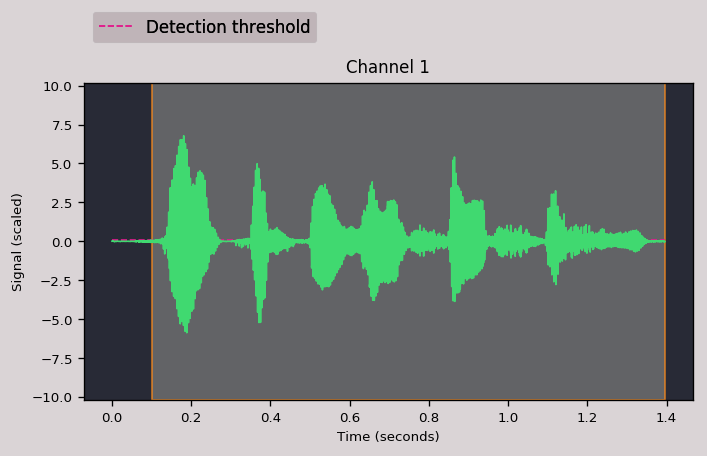

[AudioRegion(duration=1.296, sampling_rate=16000, sample_width=2, channels=1)]

In [6]:
regions.split_and_plot()

In [3]:
samples = np.asarray(gapless_region)

NameError: name 'np' is not defined

In [4]:
samples

NameError: name 'samples' is not defined

In [6]:
signal = AudioRegion.load("/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_1008492.flac").split()
gapless_region = sum(signal)
signal = np.asarray(gapless_region)
sf.write('myfile1.flac', signal, 16000)  

In [1]:
import os
os.remove('try.csv')

In [7]:
os.path.getsize("/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_1008492.flac")

29965

In [10]:
os.path.getsize('try.txt')

248965

In [14]:
import sounddevice as sd
sd.play(signal, fs)
status = sd.wait()

In [8]:
!pip install sounddevice

In [1]:
import tensorflow as tf

In [7]:
tf.keras.layers.Softmax

tensorflow.python.keras.layers.advanced_activations.Softmax

In [3]:
import keras.backend.log_softmax

Using TensorFlow backend.


ImportError: No module named 'keras.backend.log_softmax'

In [19]:
import tensorflow as tf
tf.__version__

'1.4.0'

In [8]:
!pip install tensorflow==1.4.0

  Using cached tensorflow-1.4.0-cp35-cp35m-manylinux1_x86_64.whl (40.7 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [1]:
!pip install webrtcvad

     |████████████████████████████████| 66 kB 808 kB/s eta 0:00:011
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp35-cp35m-linux_x86_64.whl size=63727 sha256=6a9a0fd16e2806e4c4516821f899025e361fcf035bd8e9fe38ac902dccf04dd3
  Stored in directory: /home/rohita/.cache/pip/wheels/1f/d0/7b/59a446d51f8accc7c24be94f93429d44ac7db12f9870dea4f9
Successfully built webrtcvad


In [1]:
import soundfile as sf
import webrtcvad
import contextlib
import sys
import collections
import wave

def read_wave(path):
    """Reads a .wav file.
    Takes the path, and returns (PCM audio data, sample rate).
    """
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate


def write_wave(path, audio, sample_rate):
    """Writes a .wav file.
    Takes path, PCM audio data, and sample rate.
    """
    with contextlib.closing(wave.open(path, 'wb')) as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(audio)


class Frame(object):
    """Represents a "frame" of audio data."""
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration


def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n


def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    """Filters out non-voiced audio frames.
    Given a webrtcvad.Vad and a source of audio frames, yields only
    the voiced audio.
    Uses a padded, sliding window algorithm over the audio frames.
    When more than 90% of the frames in the window are voiced (as
    reported by the VAD), the collector triggers and begins yielding
    audio frames. Then the collector waits until 90% of the frames in
    the window are unvoiced to detrigger.
    The window is padded at the front and back to provide a small
    amount of silence or the beginnings/endings of speech around the
    voiced frames.
    Arguments:
    sample_rate - The audio sample rate, in Hz.
    frame_duration_ms - The frame duration in milliseconds.
    padding_duration_ms - The amount to pad the window, in milliseconds.
    vad - An instance of webrtcvad.Vad.
    frames - a source of audio frames (sequence or generator).
    Returns: A generator that yields PCM audio data.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

#         sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
    sys.stdout.write('\n')
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])



In [2]:
# Extract audio data and sampling rate from file 
data, fs = sf.read("/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_7234844.flac")
sf.write('myfile.wav', data, fs)
audio, fs = read_wave('myfile.wav')
vad = webrtcvad.Vad(3)
frames = frame_generator(10, audio, fs)
frames = list(frames)
segments = vad_collector(fs, 30, 300, vad, frames)
audio = b''
for i, segment in enumerate(segments):
    if audio == False:
        audio = segment
    else:
        audio = b"".join([audio,segment])
# Save as FLAC file at correct sampling rate
write_wave('myfile_voiced1.wav', audio, fs) 

+(0.9400000000000006)-(3.609999999999967)


In [3]:
data, fs = sf.read("/home/rohita/rohit/spoof/ASVspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_8789697.wav")

In [4]:
data

array([], dtype=float64)